In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shehapkhalil_cv_data_set_path = kagglehub.dataset_download('shehapkhalil/cv-data-set')
shehapkhalil_yamlfile_path = kagglehub.dataset_download('shehapkhalil/yamlfile')
shehapkhalil_yolo_weight_path = kagglehub.dataset_download('shehapkhalil/yolo-weight')

print('Data source import complete.')


100%|██████████| 5.31M/5.31M [00:00<00:00, 34.6MB/s]

Extracting files...


100%|██████████| 5.31M/5.31M [00:00<00:00, 48.5MB/s]

Extracting files...
Data source import complete.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:

# Import the MultiObjectSameClassDatasetFixed class
class MultiObjectSameClassDatasetFixed(Dataset):
    def __init__(self, root_dir, transform=None, target_format="yolo", task="detection"):
        """
        Fixed version of MultiObjectSameClassDataset for DeepLabV3 segmentation.

        Args:
            root_dir (str): Root directory of the dataset (train/test directory).
            transform (callable, optional): Transformation to apply to images.
            target_format (str): Format of targets - "yolo", "faster_rcnn", or "retinanet".
            task (str): Task type - "detection" or "segmentation".
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_format = target_format
        self.task = task  # Either "detection" or "segmentation"

        # Collect all image and annotation paths
        self.image_paths = []
        self.annotation_paths = []
        self.mask_paths = []  # For segmentation task

        detection_dir = os.path.join(root_dir, 'detections')
        images_dir = os.path.join(root_dir, 'images')
        mask_dir = os.path.join(root_dir, 'masks')  # Folder for masks (only for segmentation)

        for folder in os.listdir(detection_dir):
            annotation_folder = os.path.join(detection_dir, folder)
            image_folder = os.path.join(images_dir, folder)
            mask_folder = os.path.join(mask_dir, folder)  # Mask folder for segmentation

            if os.path.isdir(annotation_folder) and os.path.isdir(image_folder):
                for ann_file in os.listdir(annotation_folder):
                    if ann_file.endswith('.txt'):
                        self.annotation_paths.append(os.path.join(annotation_folder, ann_file))
                        image_name = ann_file.replace('.txt', '.png')  # Assuming .png format
                        self.image_paths.append(os.path.join(image_folder, image_name))

                        if self.task == "segmentation":
                            # Add corresponding mask path for segmentation
                            mask_name = ann_file.replace('.txt', '.png')  # Assuming the mask format is also .png
                            self.mask_paths.append(os.path.join(mask_folder, mask_name))

        assert len(self.image_paths) == len(self.annotation_paths), "Mismatch between images and annotations!"
        if self.task == "segmentation":
            assert len(self.image_paths) == len(self.mask_paths), "Mismatch between images and masks!"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Load mask if the task is segmentation
        if self.task == "segmentation":
            mask_path = self.mask_paths[idx]
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
            mask = np.array(mask)

            # Binarize the mask if it's not already binary
            if mask.max() > 1:
                mask = (mask > 0).astype(np.uint8)

            # Apply transform using albumentations if provided
            if self.transform:
                # Make sure transform is albumentations transform for mask compatibility
                if isinstance(self.transform, A.Compose):
                    transformed = self.transform(image=image, mask=mask)
                    image = transformed["image"]
                    mask = transformed["mask"]
                else:
                    # Custom handling for non-albumentations transforms
                    if self.transform:
                        transformed = self.transform(image=image)
                        image = transformed["image"]

                    # Convert mask to tensor manually
                    mask = torch.from_numpy(mask).float()

            # Ensure mask has correct shape for DeepLabV3
            # For DeepLabV3, the mask should be [H, W] or [1, H, W]
            if isinstance(mask, torch.Tensor):
                # If already tensor, just ensure it's 2D or 3D with channel first
                if mask.dim() == 2:  # [H, W]
                    pass  # Already correct shape
                elif mask.dim() == 3 and mask.shape[0] == 1:  # [1, H, W]
                    pass  # Already correct shape
                elif mask.dim() == 3 and mask.shape[0] != 1:  # [H, W, 1] or similar
                    mask = mask.permute(2, 0, 1)  # Convert to [1, H, W]
            else:
                # If numpy array
                if mask.ndim == 2:  # [H, W]
                    mask = torch.from_numpy(mask).float()
                elif mask.ndim == 3 and mask.shape[2] == 1:  # [H, W, 1]
                    mask = torch.from_numpy(mask).float().permute(2, 0, 1)  # Convert to [1, H, W]
                else:
                    mask = torch.from_numpy(mask).float()

            return image, mask

        else:
            # For detection task, follow the original implementation
            height, width = image.shape[:2]  # Retrieve dimensions from NumPy array

            # Load annotation (for detection)
            ann_path = self.annotation_paths[idx]
            boxes, labels = self.load_annotation(ann_path, (width, height))

            # Transform image if needed
            if self.transform:
                transformed = self.transform(image=image)
                image = transformed["image"]

            # Format target based on the requested format
            target = self.format_target(boxes, labels, (width, height))

            return image, target

    def load_annotation(self, ann_path, img_size):
        """
        Load annotation from a file and return the raw bounding box coordinates.
        Now supports multiple bounding boxes per image (all with same class).

        Args:
            ann_path (str): Path to the annotation file.
            img_size (tuple): Size of the image (width, height).

        Returns:
            list: List of bounding boxes in the format [[xmin, ymin, xmax, ymax], ...].
            list: List of labels (all 0, as there's only one class).
        """
        boxes = []
        labels = []

        with open(ann_path, "r") as f:
            for line in f:
                # Read each line as a bounding box
                data = list(map(int, line.strip().split(",")))
                if len(data) != 4:
                    raise ValueError(f"Annotation file {ann_path} has invalid format. Expected 4 values per line.")

                x_min, y_min, x_max, y_max = data
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(0)  # All objects have the same class (0)

        return boxes, labels

    def format_target(self, boxes, labels, img_size):
        """
        Format the target based on the required target format.
        Now handles multiple boxes per image.

        Args:
            boxes (list): List of bounding boxes in [xmin, ymin, xmax, ymax] format.
            labels (list): List of class labels (all same class).
            img_size (tuple): Image size (width, height).

        Returns:
            dict: Formatted target.
        """
        width, height = img_size

        if self.target_format == "yolo":
            # Convert each bounding box to YOLO format: [label, x_center, y_center, width, height]
            formatted_boxes = []
            for box, label in zip(boxes, labels):
                yolo_box = [
                    label,
                    (box[0] + box[2]) / (2 * width),  # x_center (normalized)
                    (box[1] + box[3]) / (2 * height),  # y_center (normalized)
                    (box[2] - box[0]) / width,         # width (normalized)
                    (box[3] - box[1]) / height         # height (normalized)
                ]
                formatted_boxes.append(yolo_box)
            return {"boxes": formatted_boxes, "labels": labels}

        elif self.target_format in ["faster_rcnn", "retinanet"]:
            # Convert to tensors for Faster R-CNN or RetinaNet
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)  # Box coordinates as tensor
            labels_tensor = torch.tensor(labels, dtype=torch.int64)  # Labels as tensor
            return {"boxes": boxes_tensor, "labels": labels_tensor}

# Add a modified version of the MultiObjectSameClassDatasetFixed for box-based cropping
class BoxCroppedSegmentationDataset(MultiObjectSameClassDatasetFixed):
    def __init__(self, root_dir, transform=None, target_format="yolo", max_boxes_per_image=1):
        """
        Modified version of MultiObjectSameClassDatasetFixed that crops images based on bounding boxes.

        Args:
            root_dir (str): Root directory of the dataset (train/test directory).
            transform (callable, optional): Transformation to apply to images.
            target_format (str): Format of targets - "yolo", "faster_rcnn", or "retinanet".
            max_boxes_per_image (int): Maximum number of boxes to crop per image (default: 1)
        """
        super().__init__(root_dir, transform, target_format, task="detection")
        self.max_boxes_per_image = max_boxes_per_image

        # Create a mapping for masks since we need them for segmentation
        self.mask_mapping = {}
        for img_path in self.image_paths:
            img_dir, img_name = os.path.split(img_path)
            parent_dir = os.path.dirname(img_dir)
            mask_dir = os.path.join(parent_dir, "masks", os.path.basename(img_dir))
            mask_path = os.path.join(mask_dir, img_name)
            self.mask_mapping[img_path] = mask_path

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        ann_path = self.annotation_paths[idx]
        mask_path = self.mask_mapping.get(img_path)

        # Load image using OpenCV for consistency
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                # Try with PIL if OpenCV fails
                mask = np.array(Image.open(mask_path).convert('L'))
        else:
            # Create an empty mask if no mask file exists
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Binarize the mask if it's not already binary
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Get image dimensions
        height, width = image.shape[:2]

        # Load bounding boxes (format: [x_min, y_min, x_max, y_max])
        boxes, _ = self.load_annotation(ann_path, (width, height))

        # If no boxes, return the whole image
        if not boxes:
            # Apply transformations to the whole image
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']

            return image, mask

        # Select a random box if there are multiple
        if len(boxes) > self.max_boxes_per_image:
            indices = np.random.choice(len(boxes), self.max_boxes_per_image, replace=False)
            selected_boxes = [boxes[i] for i in indices]
        else:
            selected_boxes = boxes[:self.max_boxes_per_image]

        # Choose one box randomly for this iteration
        box_idx = np.random.randint(0, len(selected_boxes))
        box = selected_boxes[box_idx]

        # Extract coordinates
        x_min, y_min, x_max, y_max = box

        # Ensure coordinates are within image bounds
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(width, x_max), min(height, y_max)

        # Crop image and mask
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=cropped_image, mask=cropped_mask)
            cropped_image = transformed['image']
            cropped_mask = transformed['mask']

        return cropped_image, cropped_mask









In [51]:


# Define transformations
train_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Dataset and DataLoader setup
def create_dataloaders(train_dir, val_dir, batch_size):
    # Create datasets
    train_dataset = MultiObjectSameClassDatasetFixed(
        root_dir=train_dir,
        transform=train_transform,
        target_format="yolo",  # Not really used for segmentation
        task="segmentation"
    )

    val_dataset = MultiObjectSameClassDatasetFixed(
        root_dir=val_dir,
        transform=val_transform,
        target_format="yolo",  # Not really used for segmentation
        task="segmentation"
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

# Initialize DeepLabV3 model
def get_deeplabv3_model(num_classes=1):
    # Initialize model with pretrained weights
    model = deeplabv3_resnet50(pretrained=True)

    # Modify the classifier for binary segmentation (foreground/background)
    model.classifier[4] = nn.Conv2d(
        in_channels=256,
        out_channels=num_classes,
        kernel_size=1,
        stride=1
    )

    return model

# Define loss function for segmentation
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - dice

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(CombinedLoss, self).__init__()
        self.weight = weight
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        dice = dice_loss(pred, target)

        return bce * self.weight + dice * (1 - self.weight)

# Training function
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        # Move data to device
        images = images.to(device)
        masks = masks.float().unsqueeze(1).to(device)  # Add channel dimension and convert to float

        # Forward pass
        outputs = model(images)['out']

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            # Move data to device
            images = images.to(device)
            masks = masks.float().unsqueeze(1).to(device)  # Add channel dimension and convert to float

            # Forward pass
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Evaluate model and generate visualization
def evaluate_and_visualize(model, dataloader, device, num_samples=50):
    model.eval()

    # Get some random images from validation set
    dataiter = iter(dataloader)
    figures = []

    for i in range(min(num_samples, len(dataloader))):
        images, masks = next(dataiter)

        # Move to device
        images = images.to(device)
        masks = masks.to(device)

        # Get predictions
        with torch.no_grad():
            preds = model(images)['out']
            preds = torch.sigmoid(preds) > 0.5

        # Move back to CPU for visualization
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
        preds = preds.cpu().numpy()

        # Convert from tensor format
        images = np.transpose(images, (0, 2, 3, 1))
        # Denormalize images
        images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        images = np.clip(images, 0, 1)

        # Plot the results
        for j in range(min(3, len(images))):
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(images[j])
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[j], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds[j, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            figures.append(plt)

    return figures

# Main training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, save_dir='checkpoints'):
    # Create directory to save checkpoints
    os.makedirs(save_dir, exist_ok=True)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss = validate(model, val_loader, criterion, device)

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print("Saved best model checkpoint!")

        # Save last model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, os.path.join(save_dir, 'last_model.pth'))

    return model, history

# Training parameter configuration


In [37]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Paths to dataset directories
train_dir = shehapkhalil_cv_data_set_path+"/train"
val_dir = shehapkhalil_cv_data_set_path+"/val"

# Hyperparameters
batch_size = 8
num_epochs = 20
learning_rate = 3e-4
weight_decay = 1e-4

# Create dataloaders
train_loader, val_loader = create_dataloaders(train_dir, val_dir, batch_size)

# Initialize model
model = get_deeplabv3_model(num_classes=1)  # Binary segmentation
model = model.to(device)

# Define loss function and optimizer
criterion = CombinedLoss(weight=0.7)  # Weighted combination of BCE and Dice Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)





In [ ]:
# Train the model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    scheduler=scheduler
)
print("Training completed!")

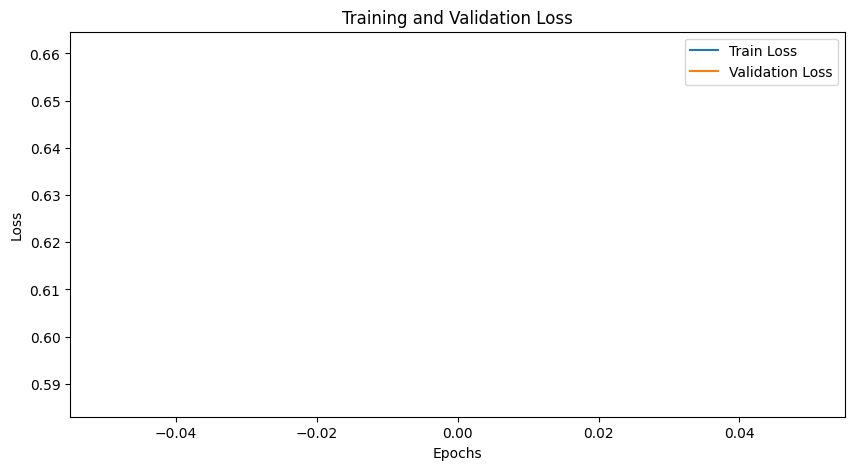

In [22]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()

# Evaluate and visualize results


In [31]:
checkpoint = torch.load('/content/drive/MyDrive/full_seg_best_model.pth')
model2 = get_deeplabv3_model(num_classes=1)  # Binary segmentation
optimizer2 = torch.optim.Adam(model2.parameters())
model2.load_state_dict(checkpoint['model_state_dict'])
model2 = model2.to(device)
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

<ipython-input-51-e2c716101494>:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


TypeError: close() argument must be a Figure, an int, a string, or None, not <class 'module'>

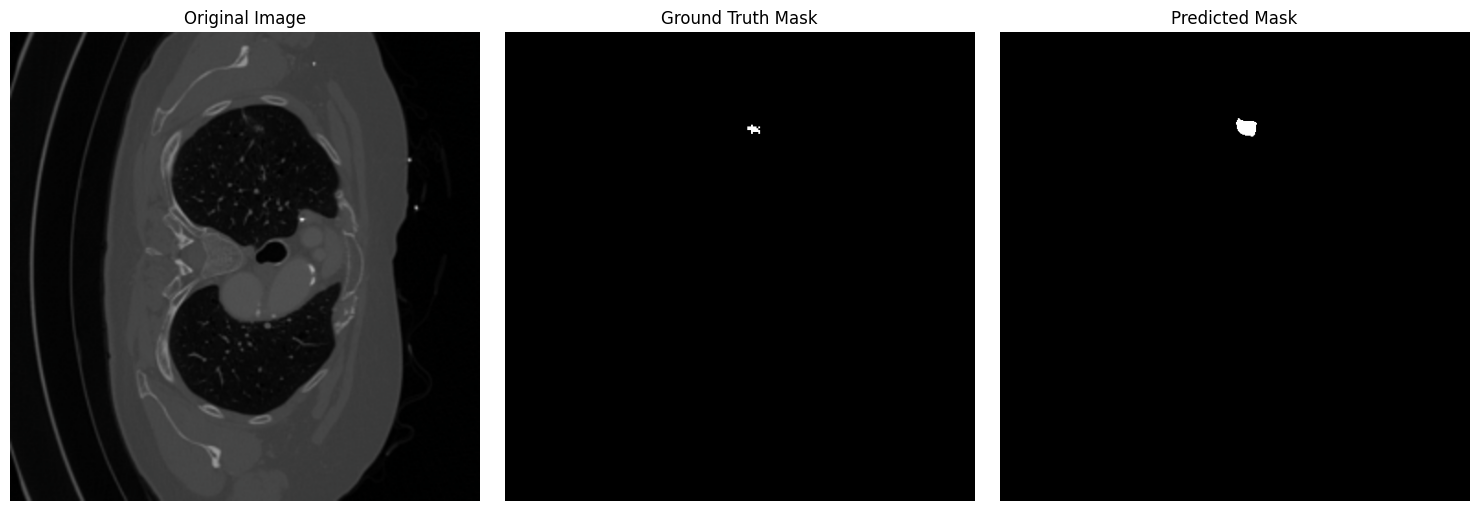

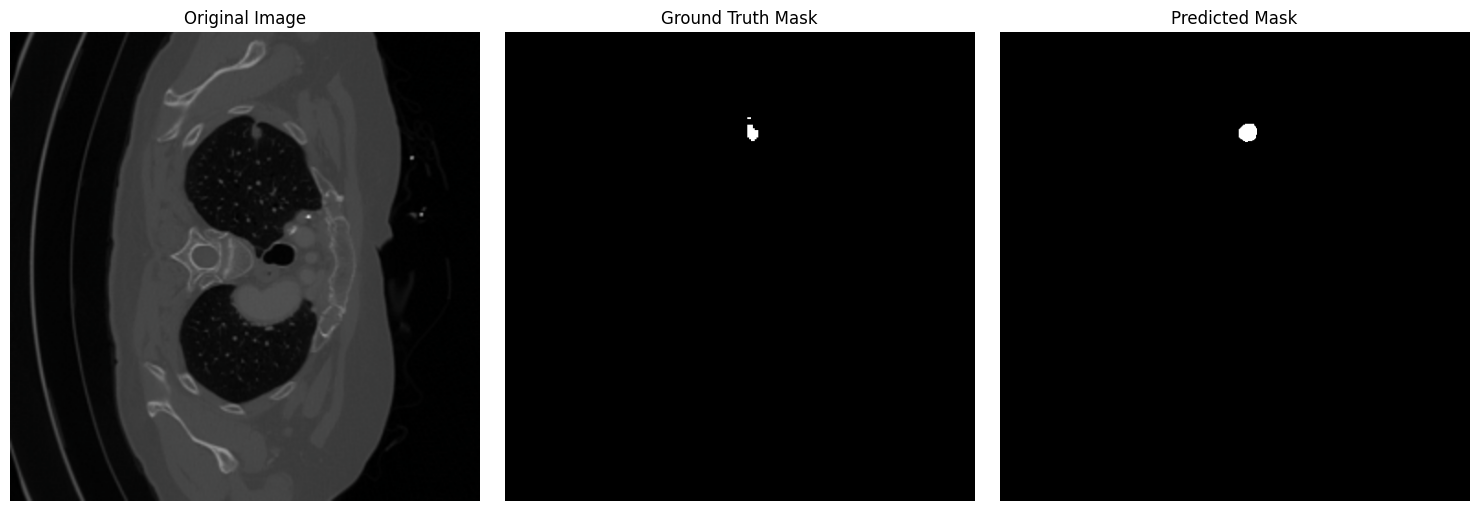

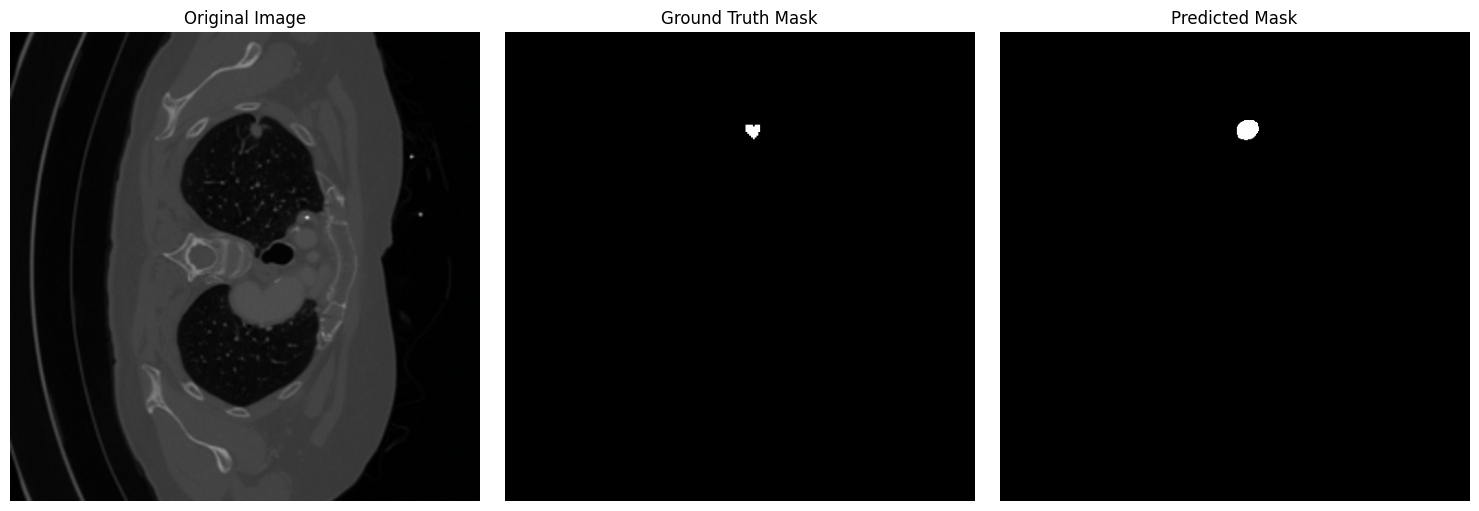

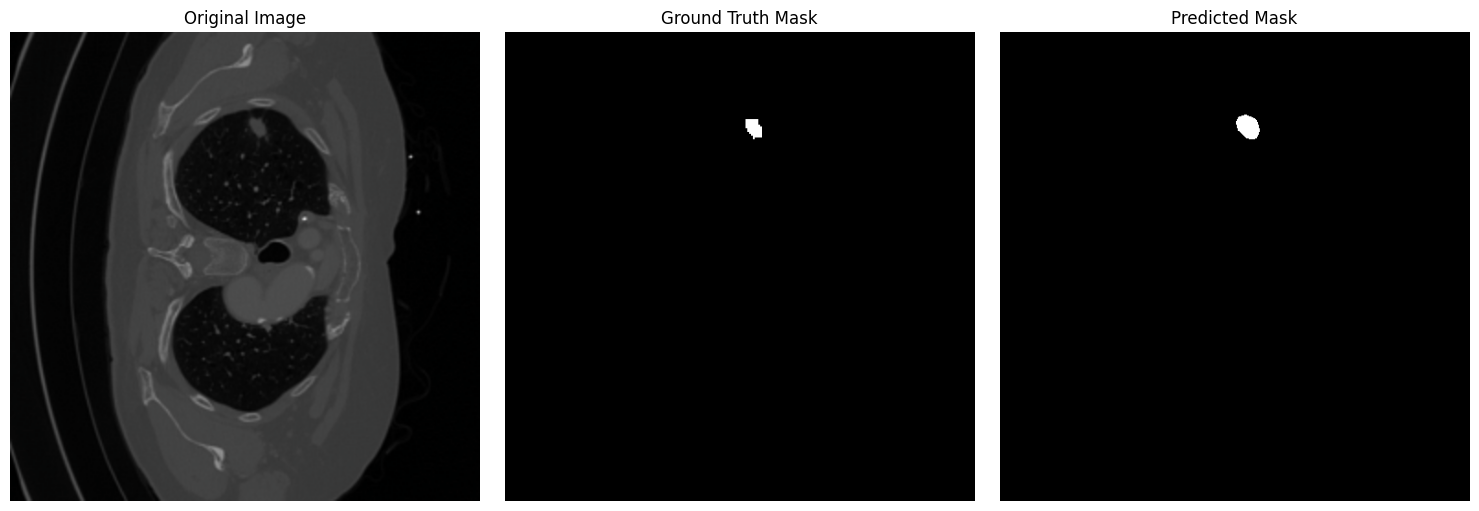

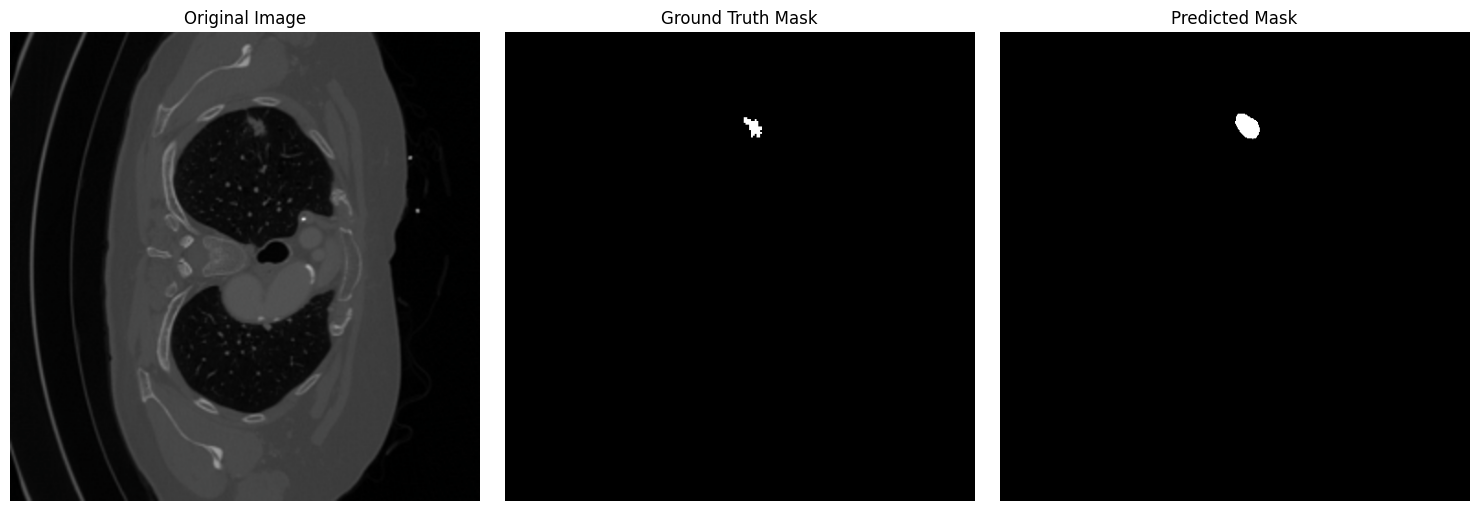

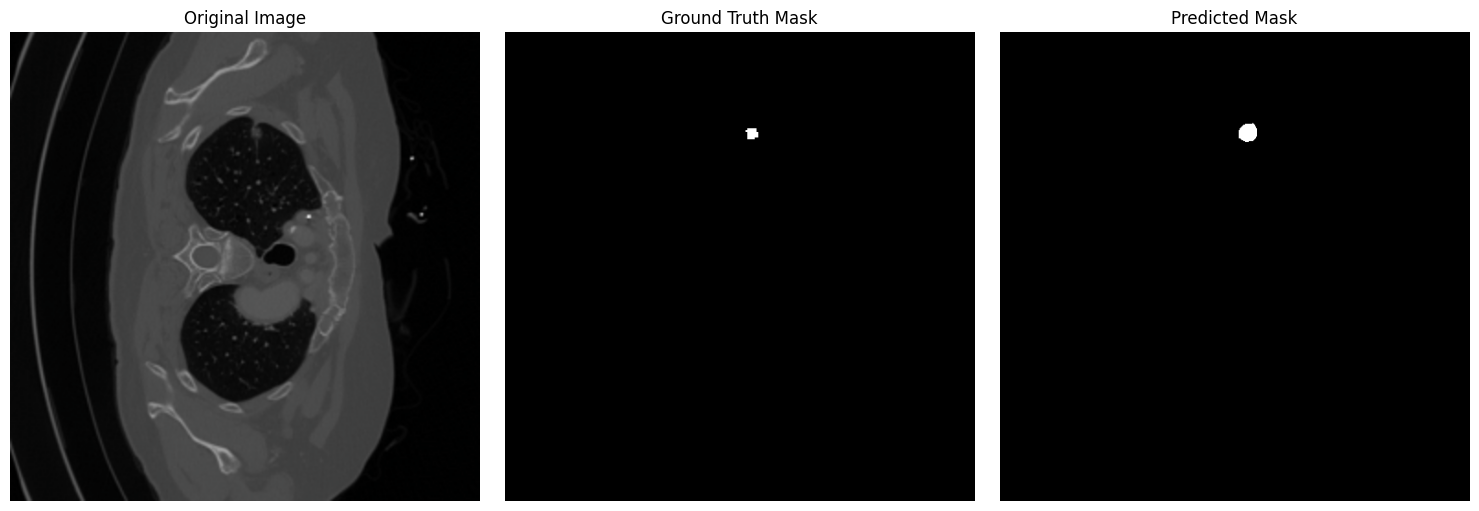

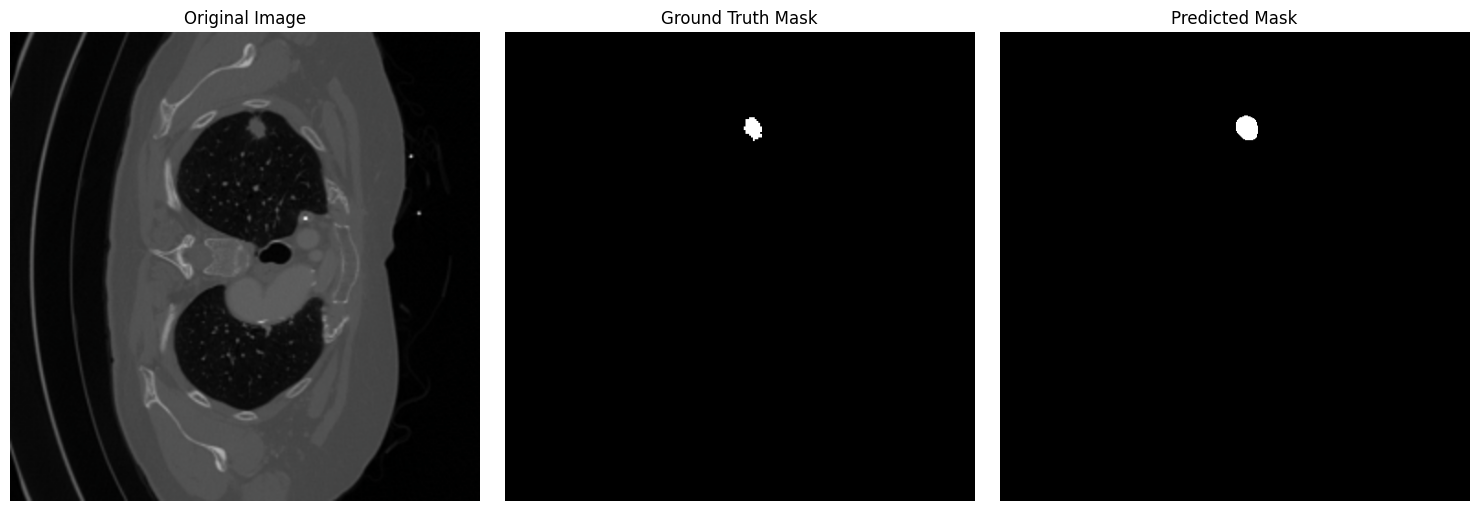

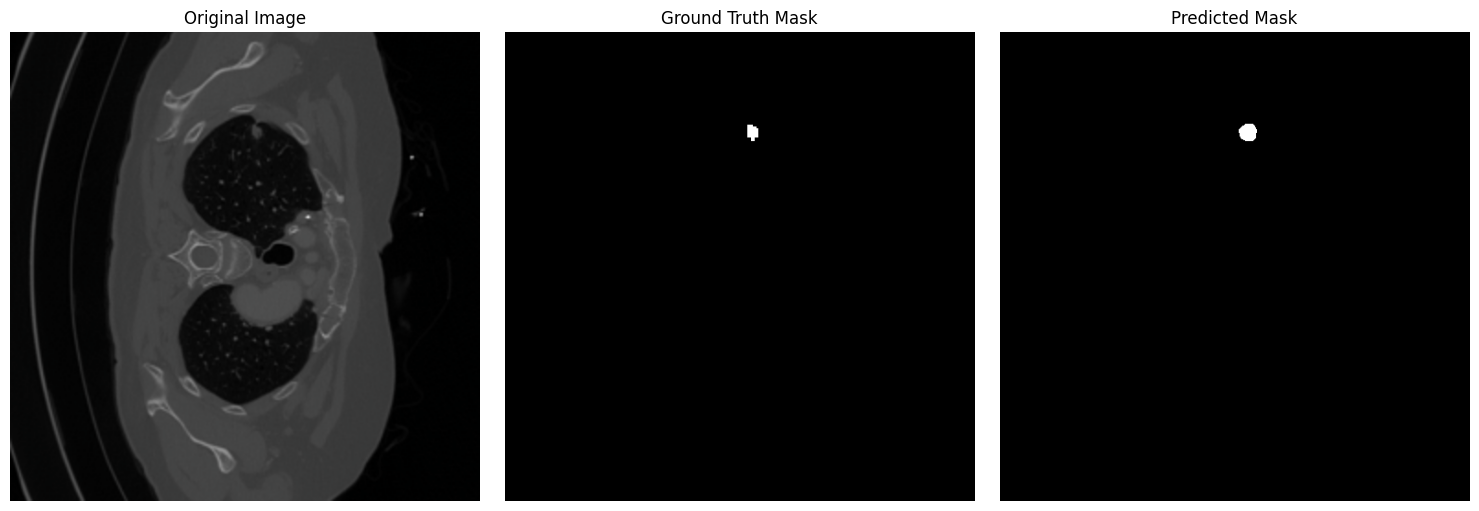

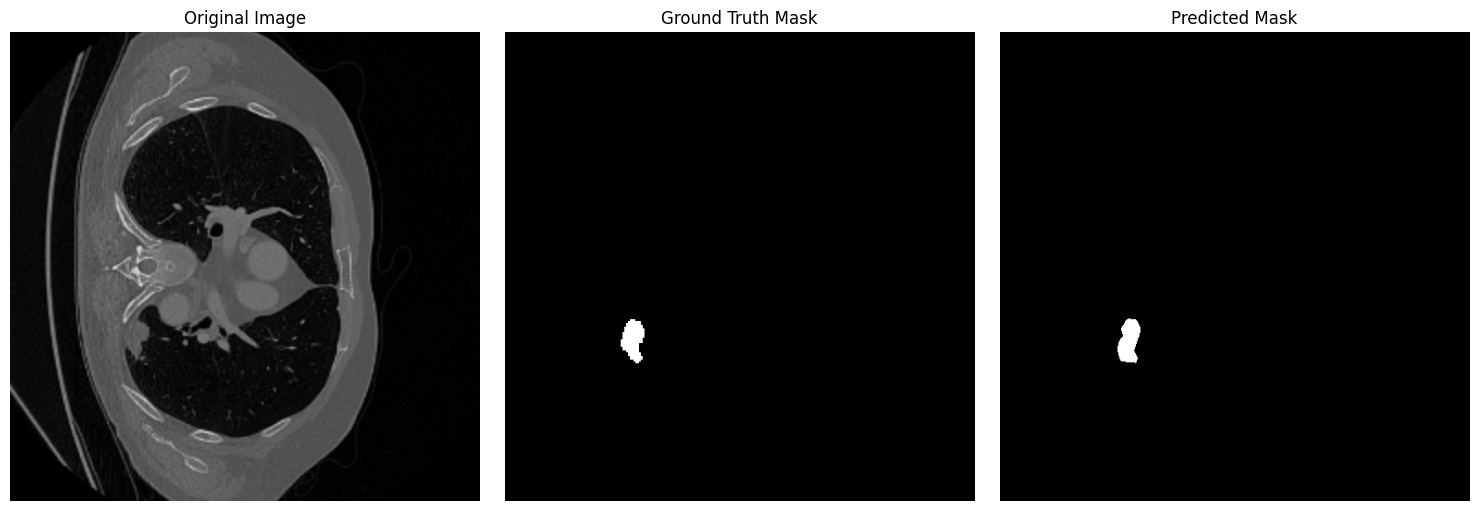

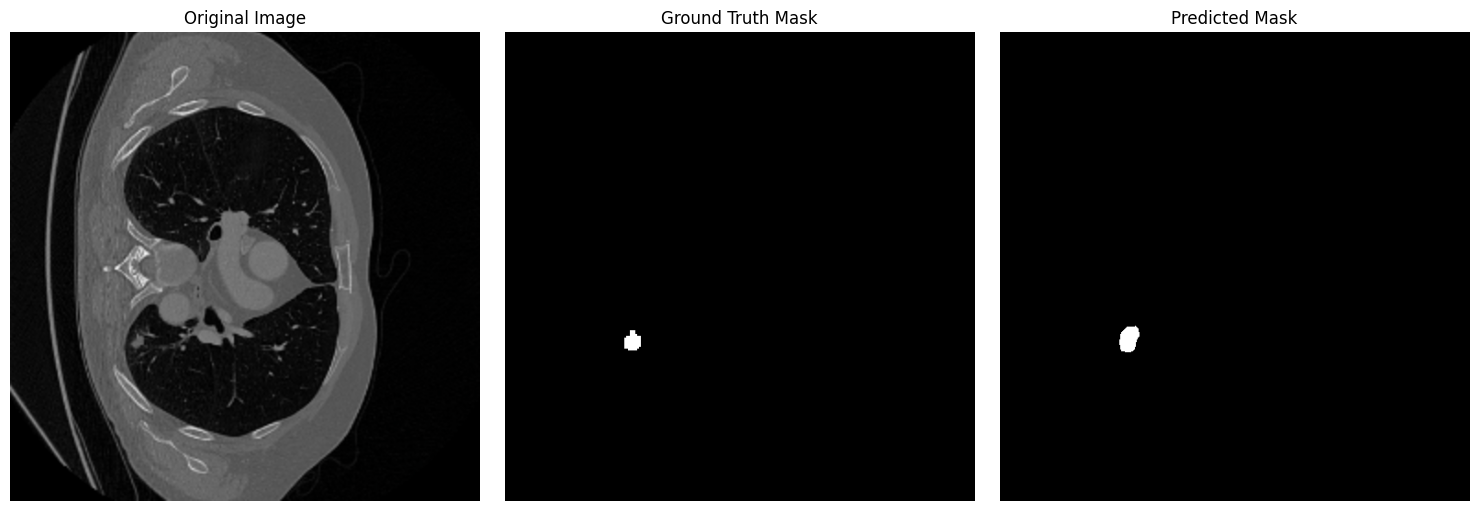

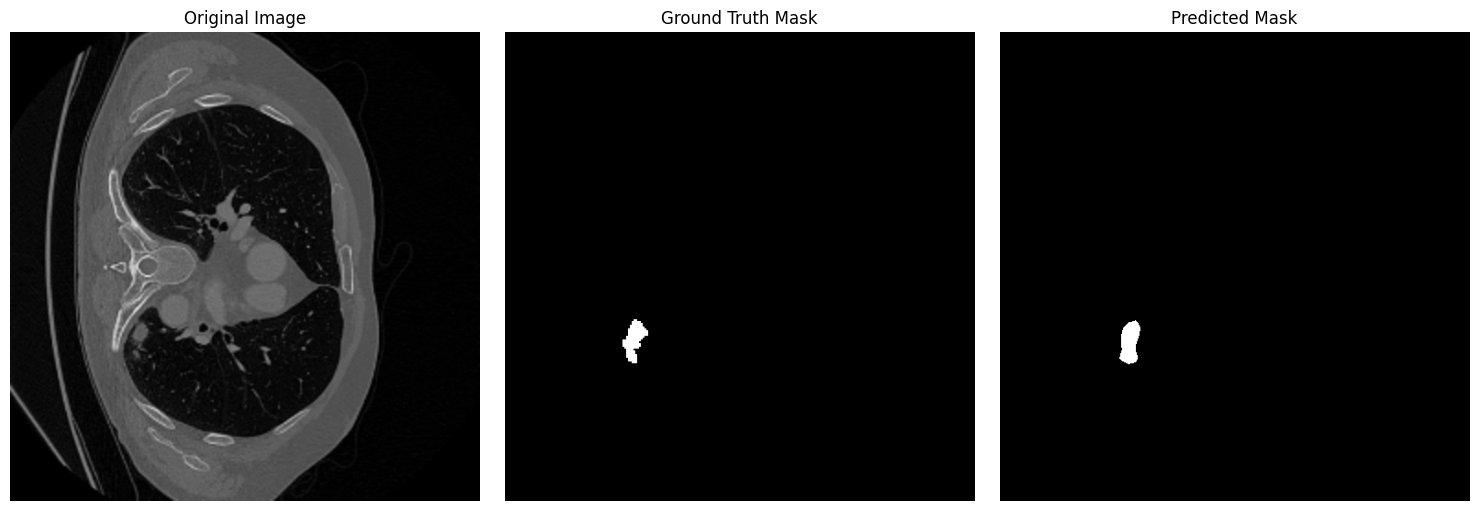

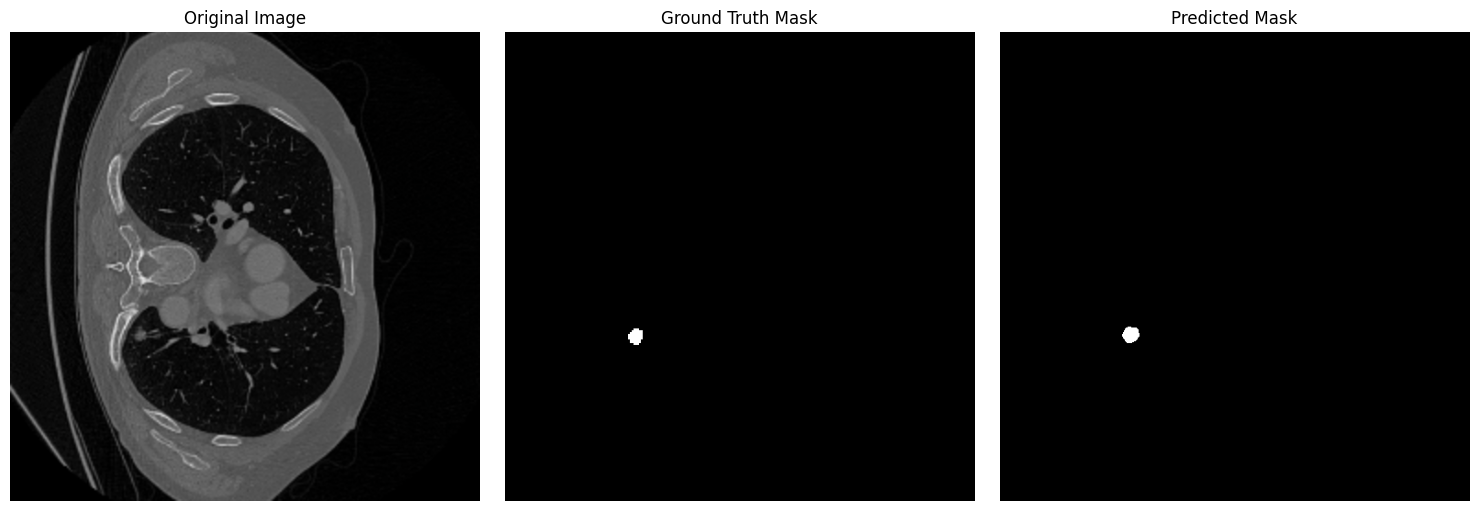

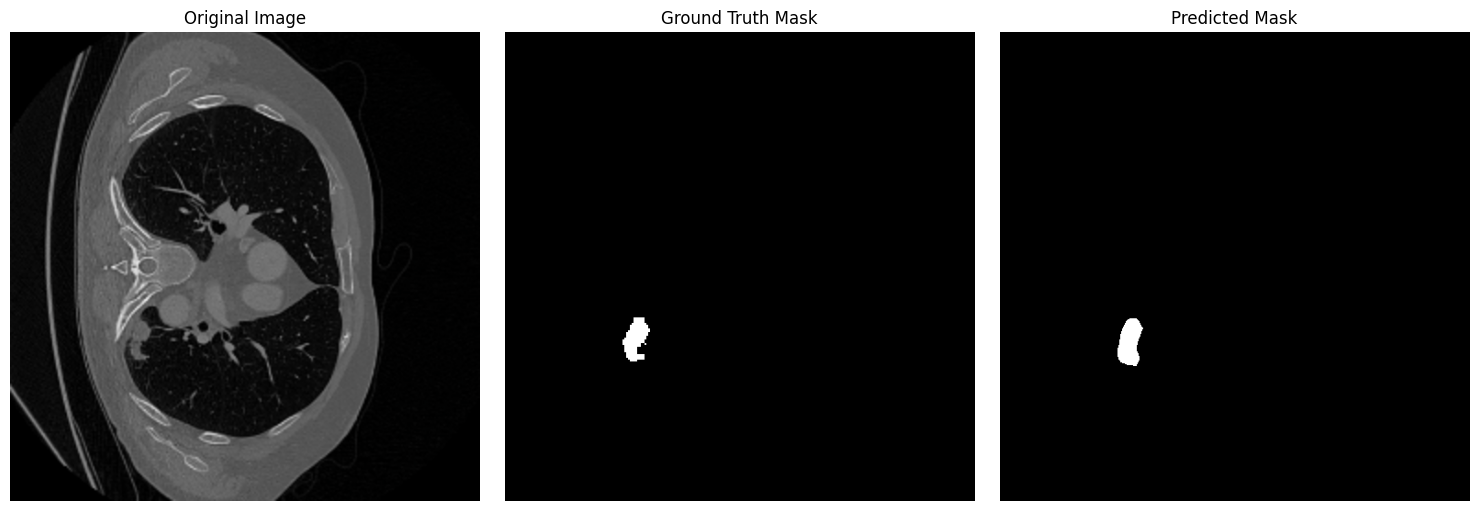

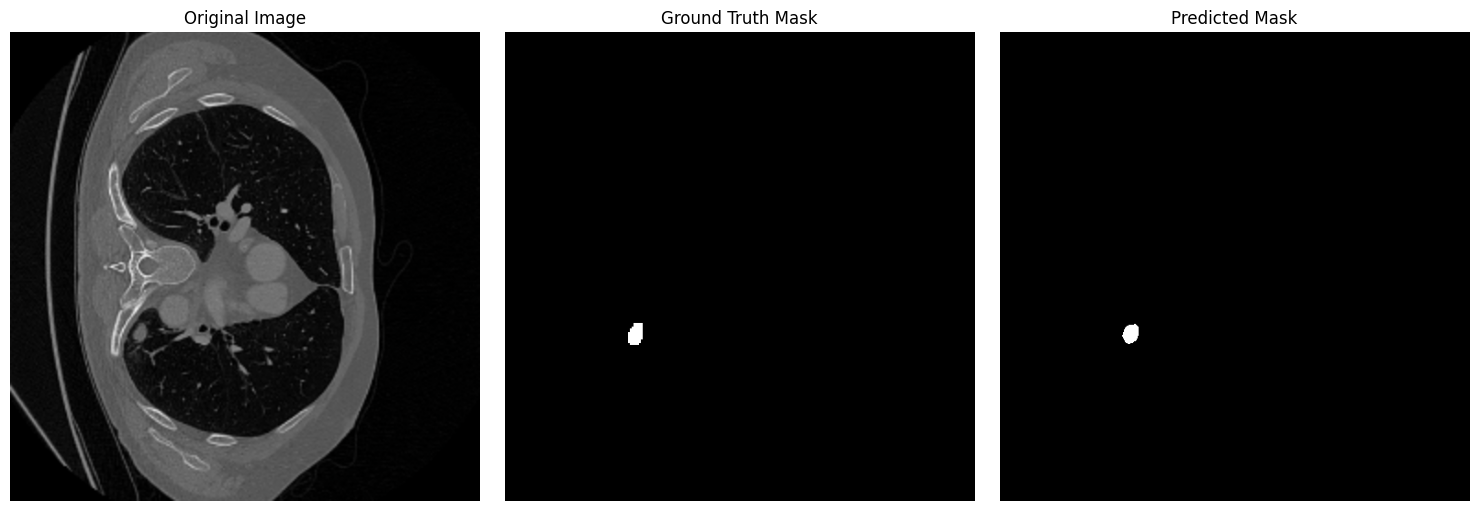

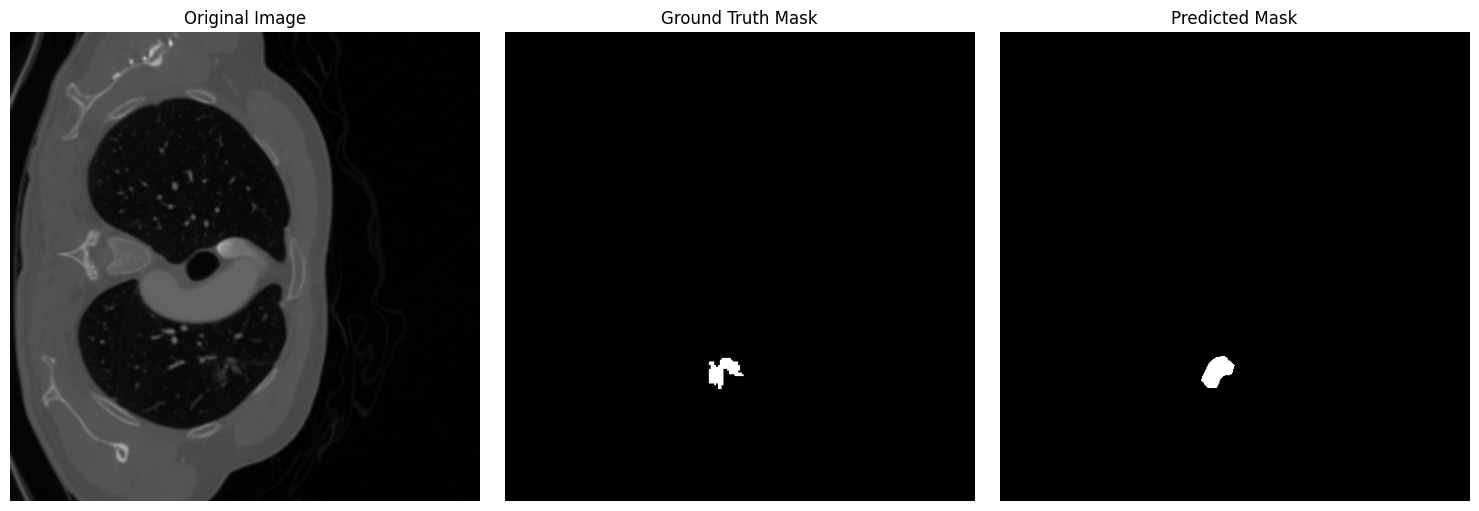

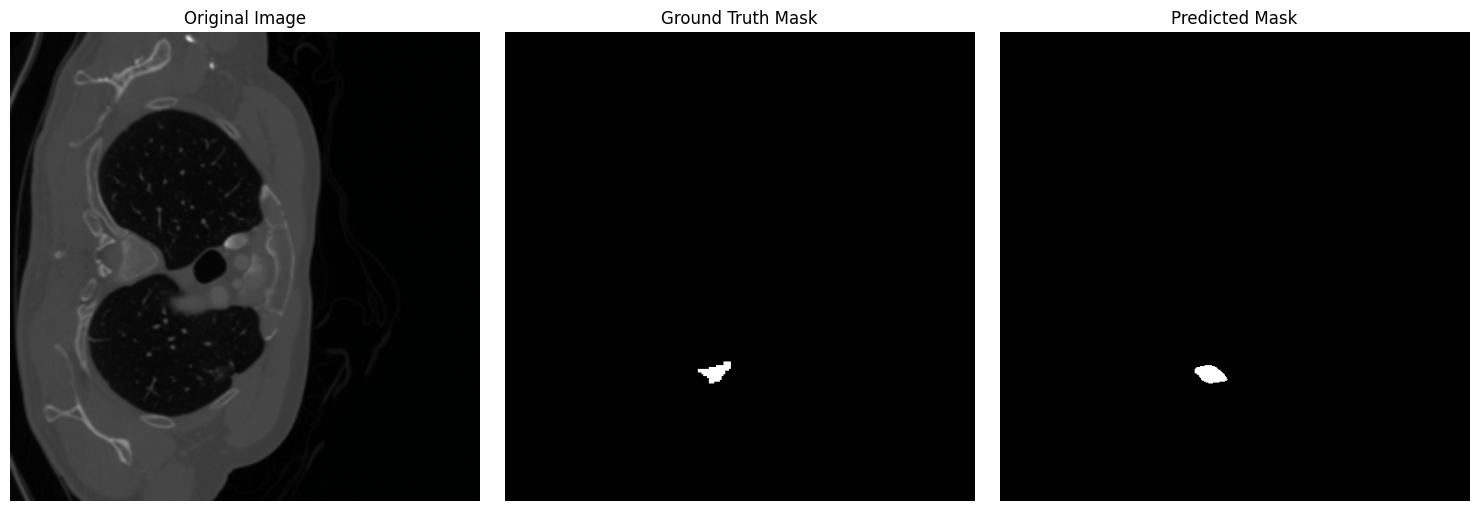

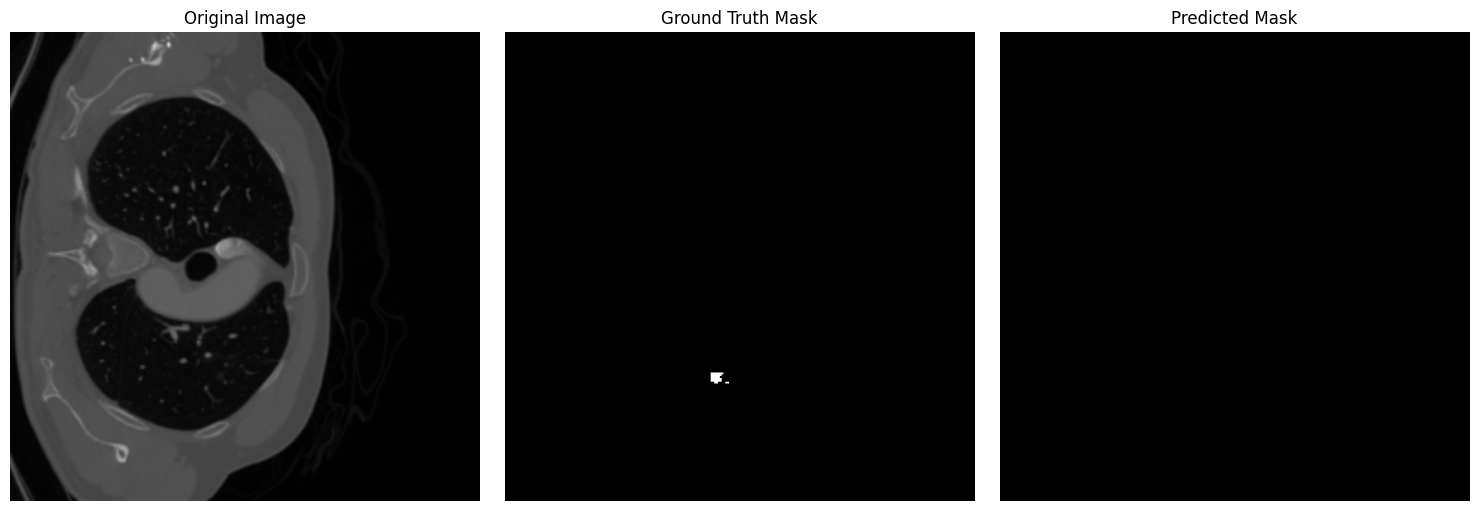

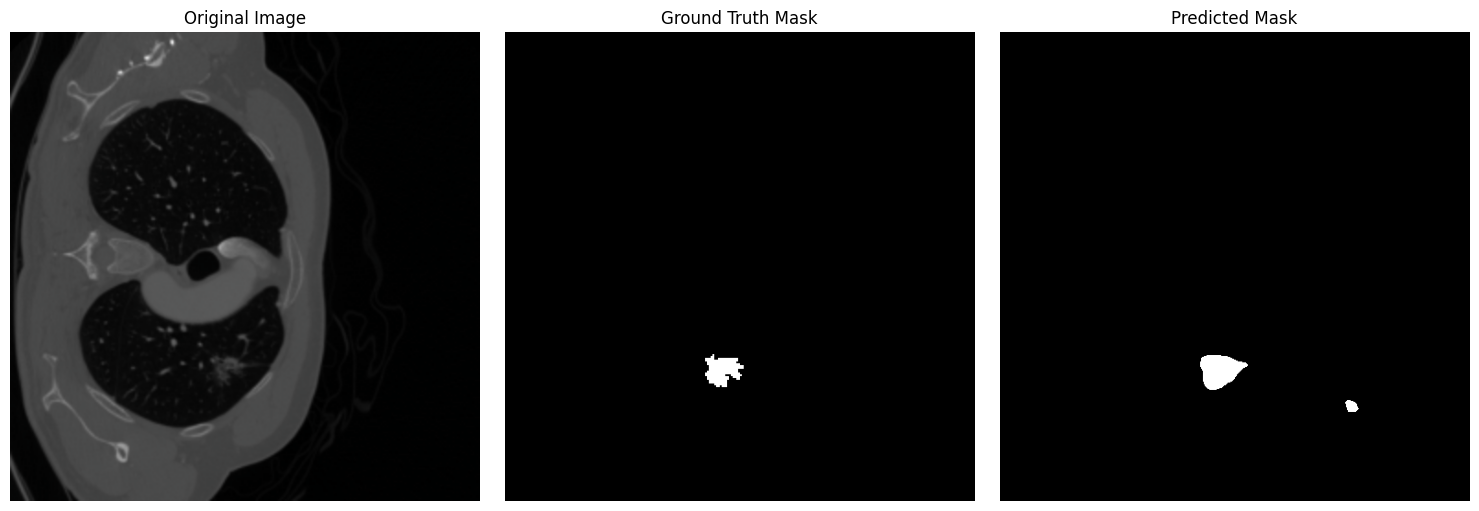

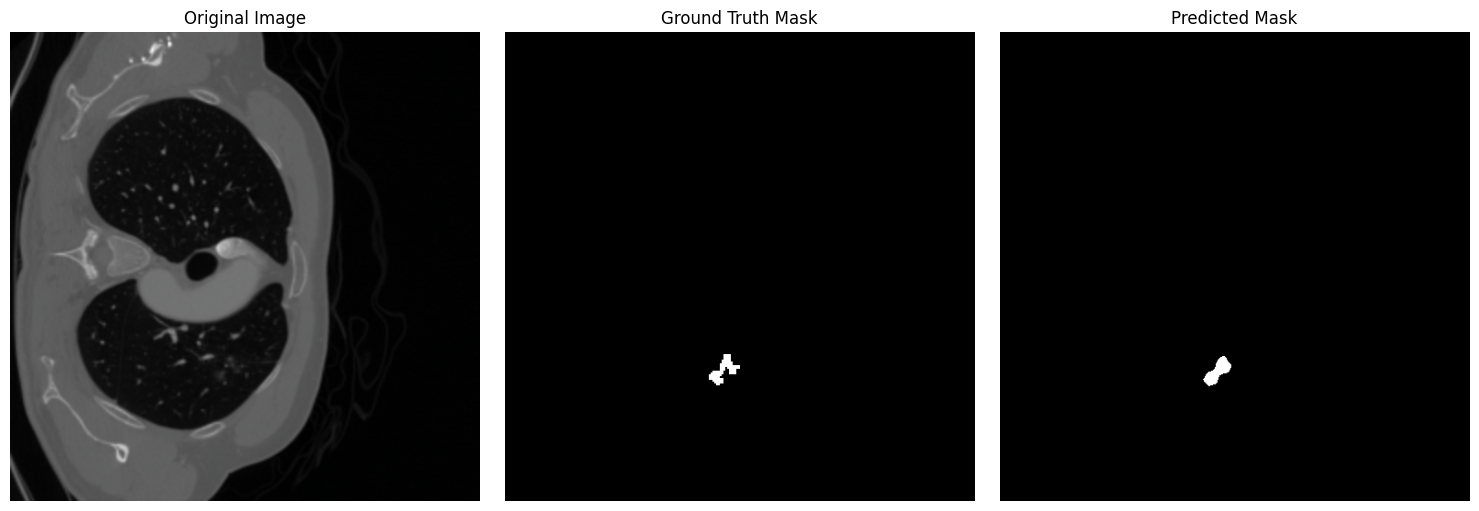

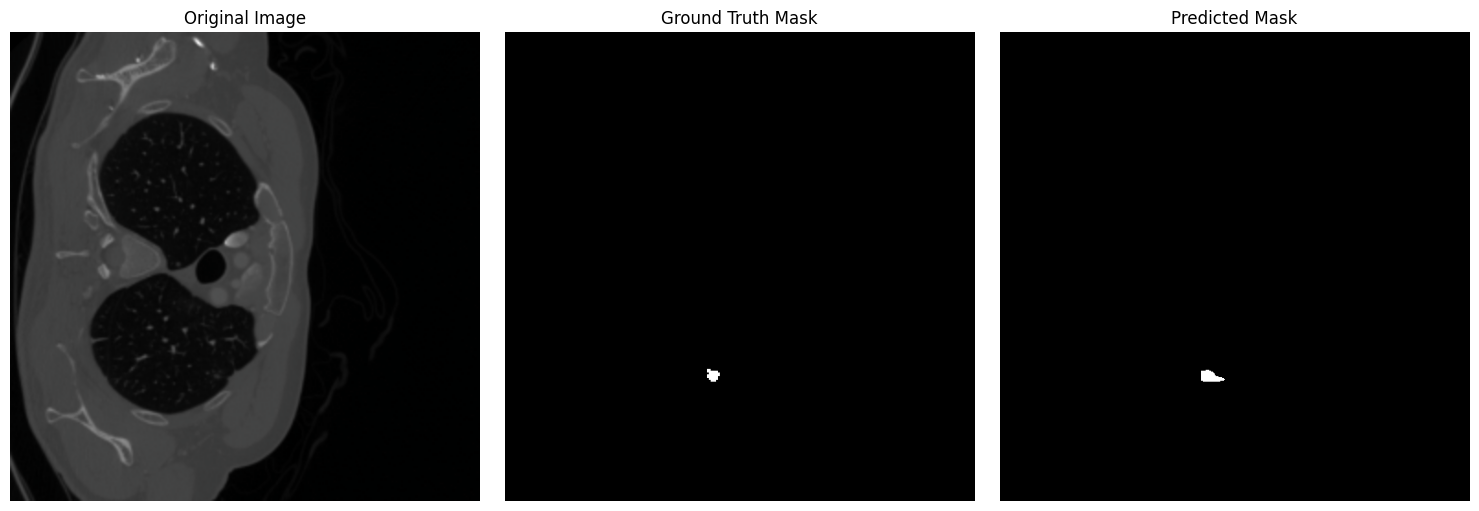

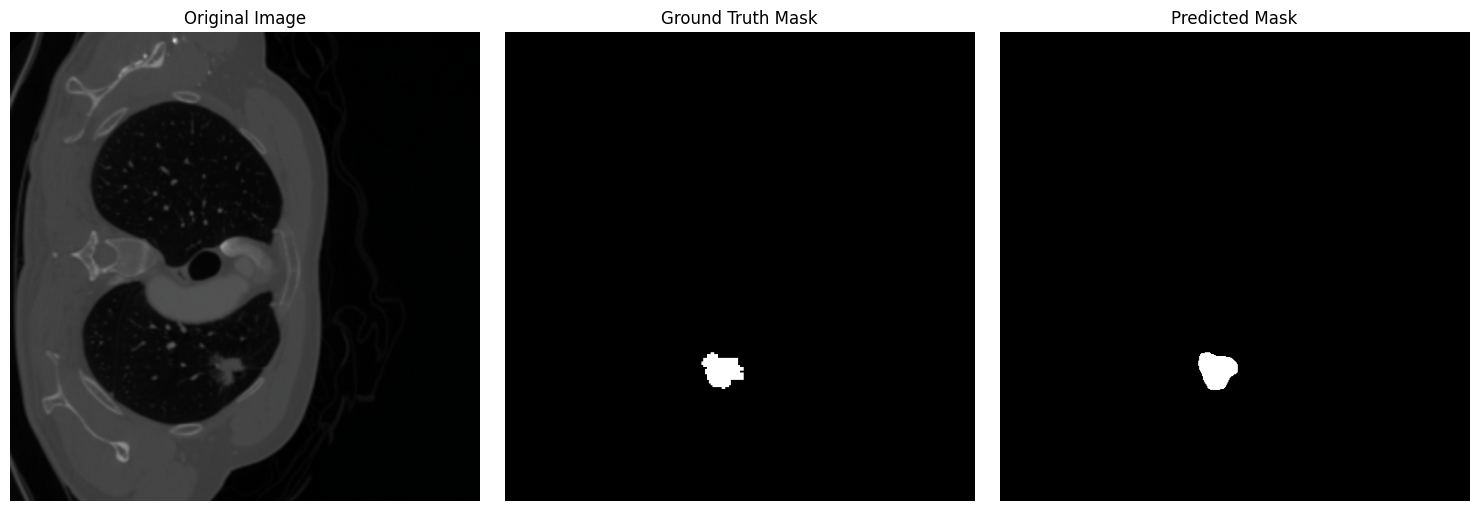

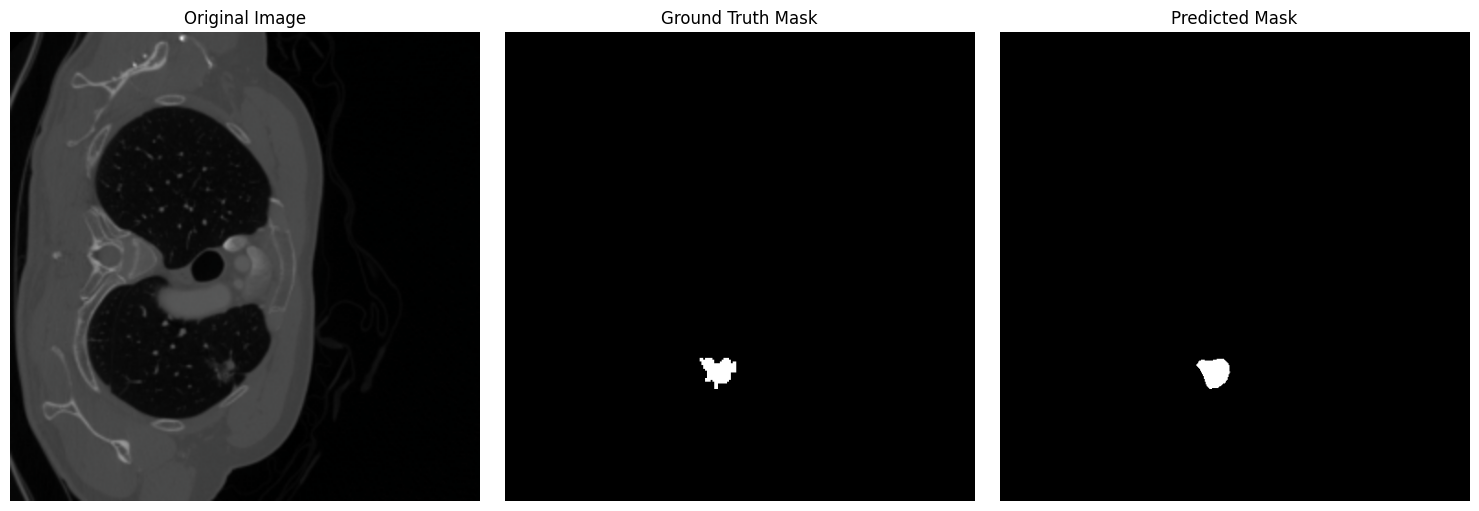

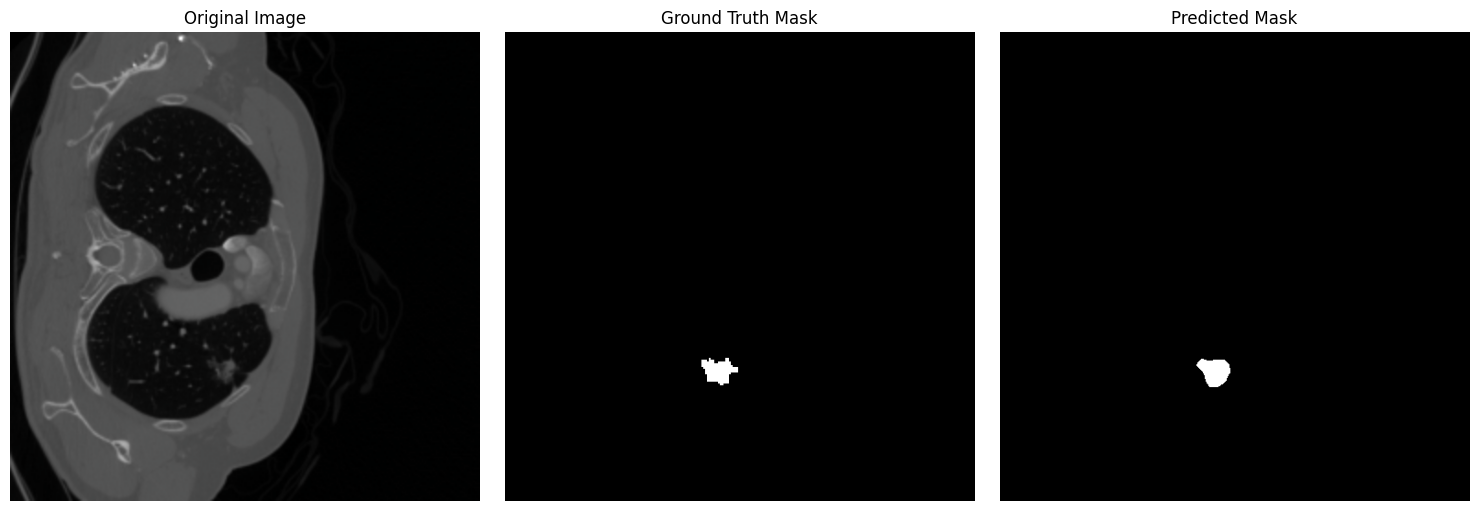

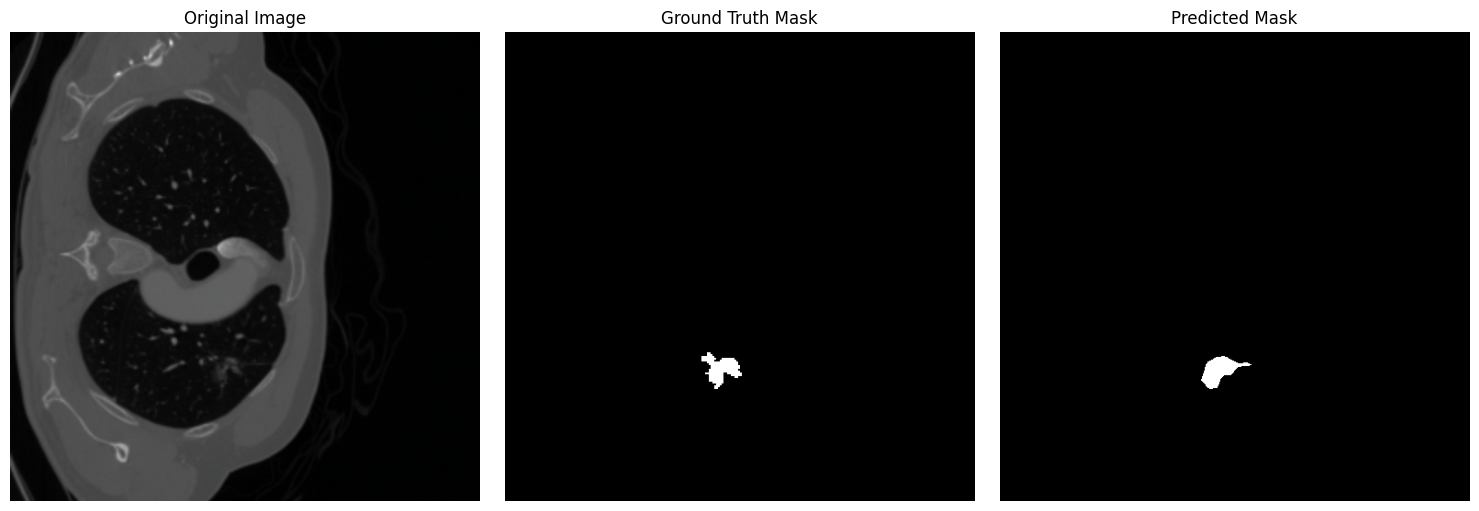

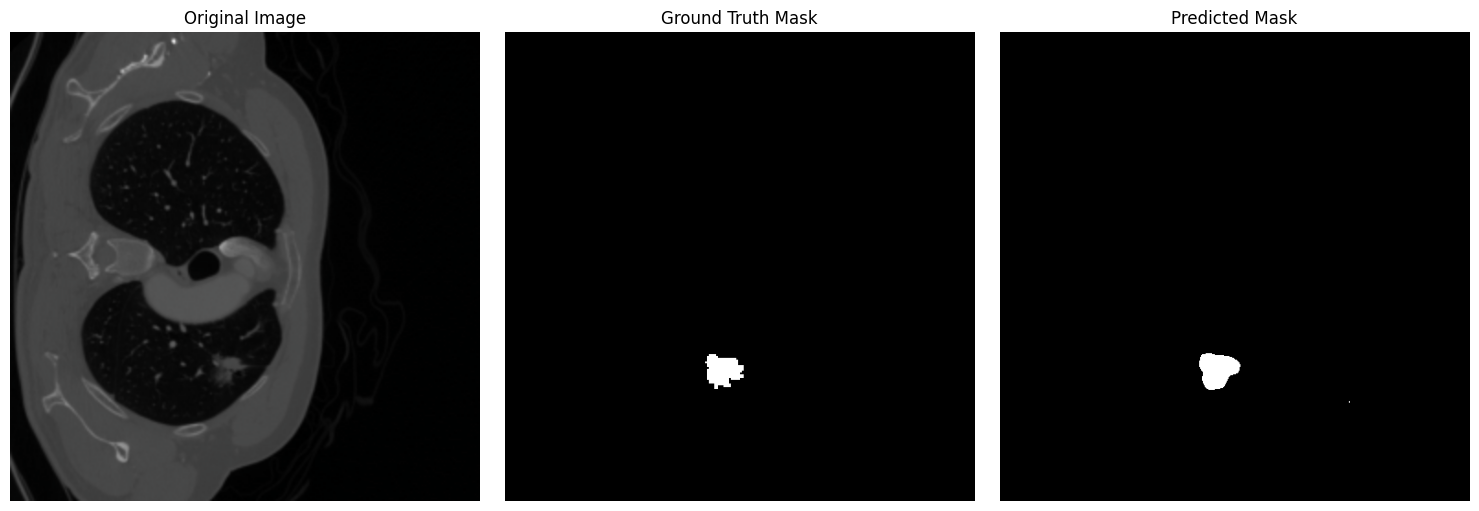

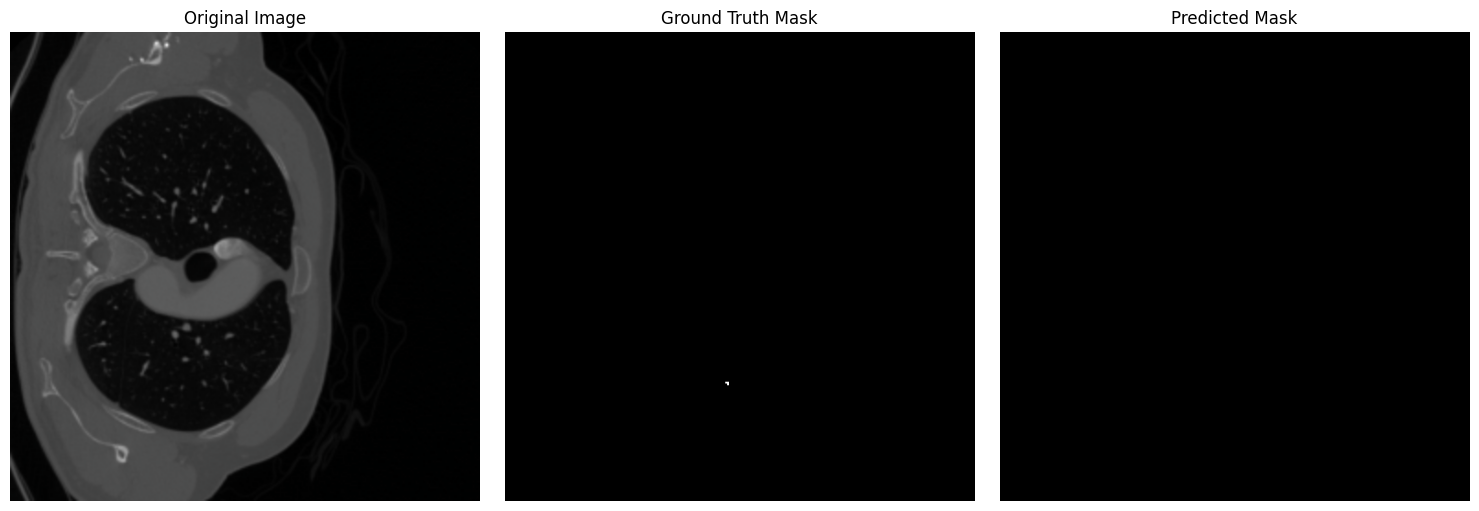

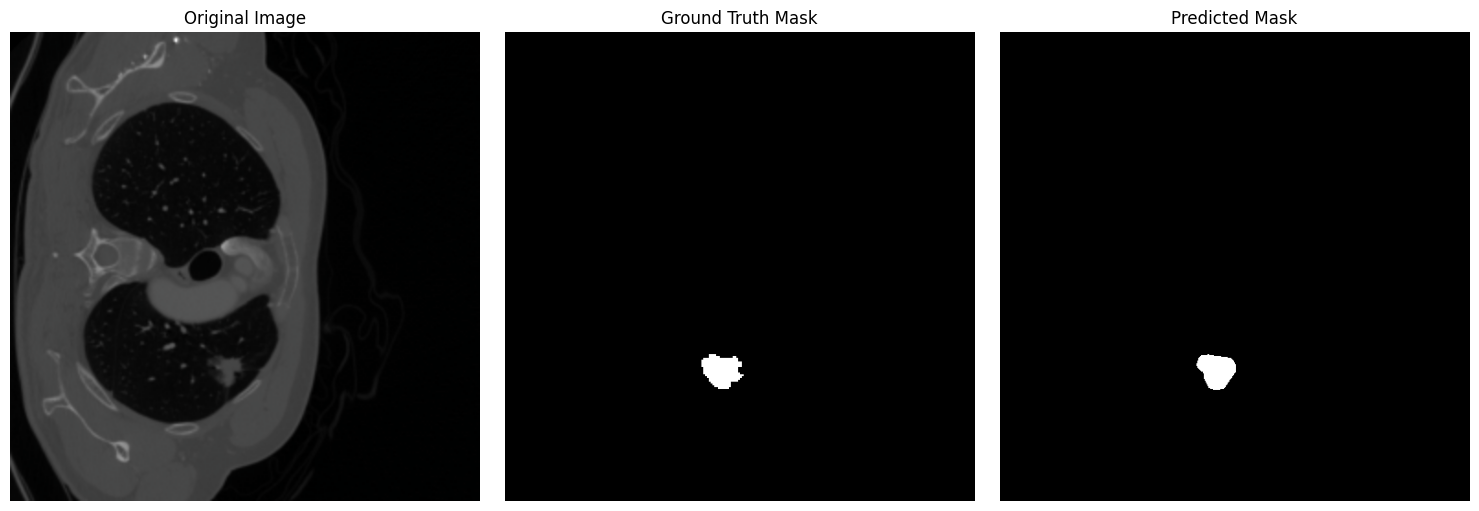

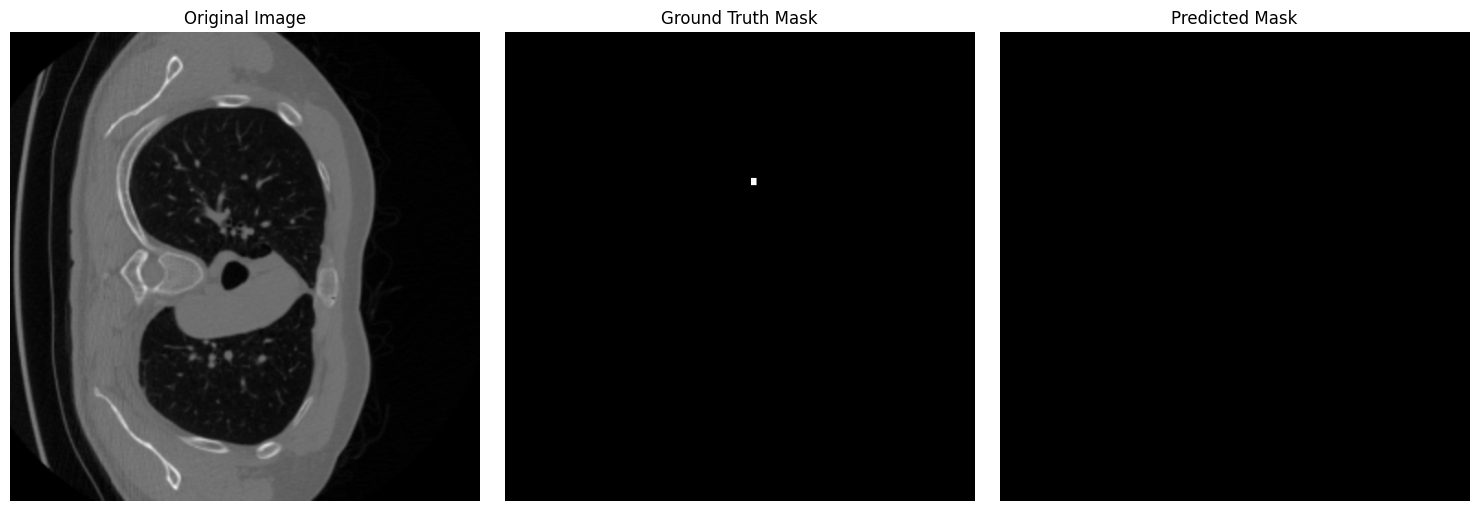

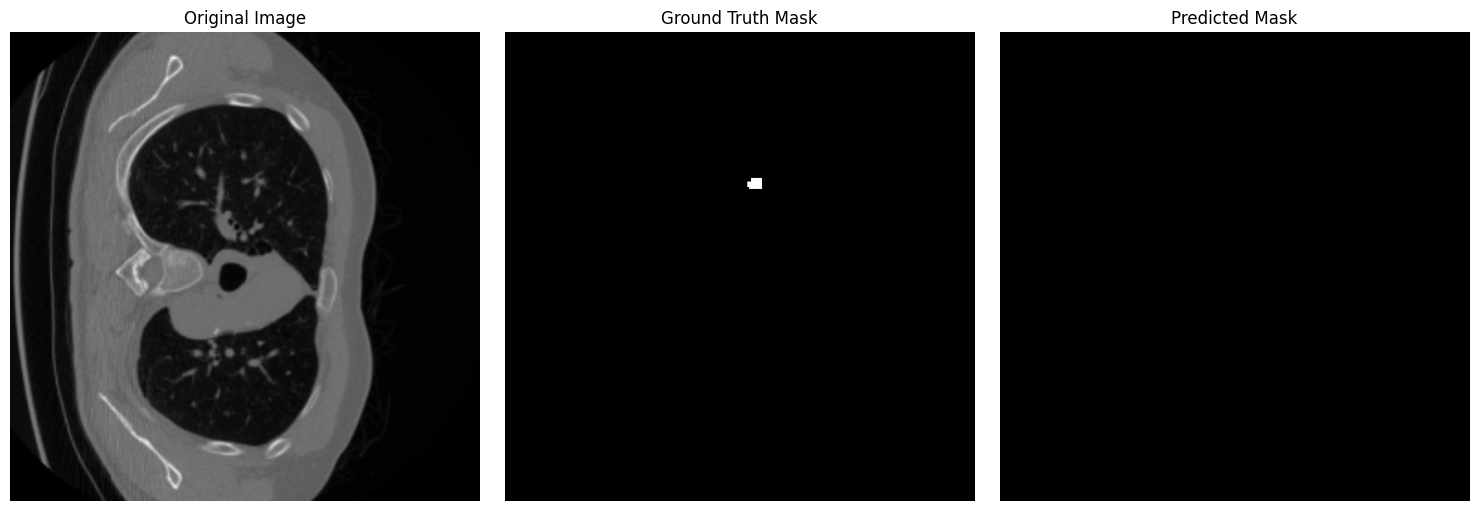

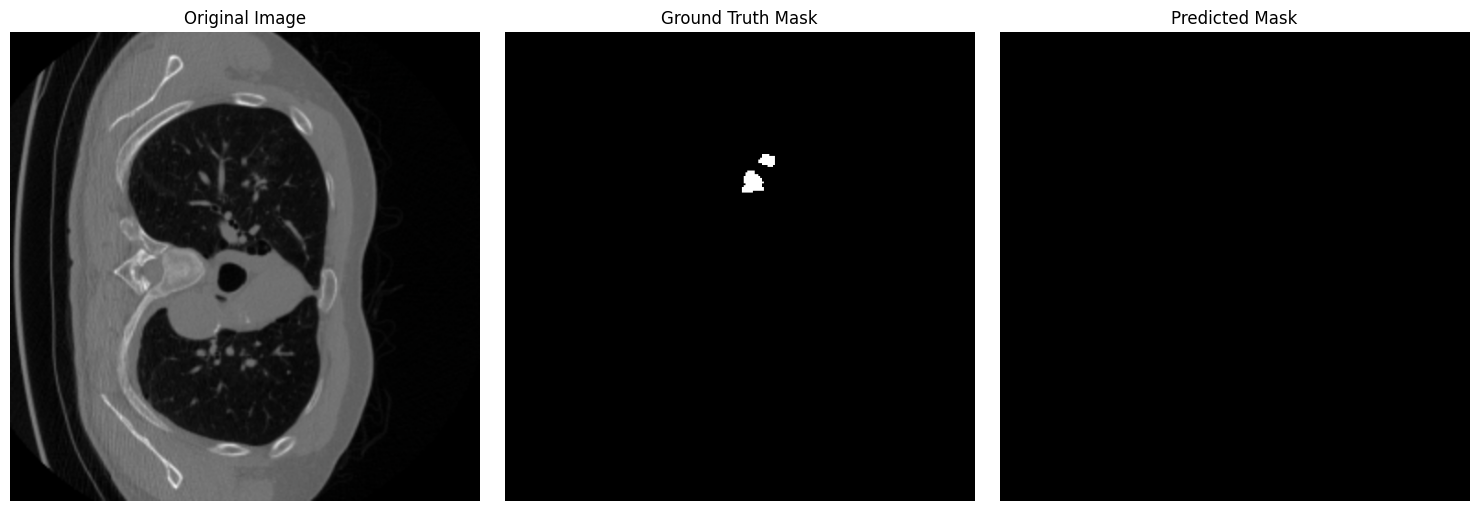

In [52]:
figures = evaluate_and_visualize(model2, val_loader, device)
for i, fig in enumerate(figures):
    fig.savefig(f'segmentation_result_{i}.png')
    plt.close(fig)

In [ ]:
torch.save({

                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),

            }, os.path.join(".", 'best_model.pth'))

In [49]:
def validate_model(loader, model, loss_fn, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.float().to(device).unsqueeze(1)


            logits = model(images)
            if isinstance(logits, dict):
                logits = logits['out']
            loss = loss_fn(logits, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).float()

            num_correct += (preds == masks).sum().item()
            num_pixels += torch.numel(preds)

            dice_score += (2 * (preds * masks).sum().item()) / (
                (preds + masks).sum().item() + 1e-8
            )

    avg_loss = total_loss / len(loader)
    avg_dice = dice_score / len(loader)
    acc = num_correct / num_pixels * 100

    print(f"[Validation] Acc: {acc:.2f}%, Dice: {avg_dice:.4f}, Loss: {avg_loss:.4f}")
    return avg_loss, avg_dice

In [50]:
class BCEDiceLoss(torch.nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        smooth = 1e-6
        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2 * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

loss_fn = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5).to(device)
validate_model(val_loader, model2, loss_fn)

Validation: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

[Validation] Acc: 99.90%, Dice: 0.7287, Loss: 0.2158


(0.21581505089998246, 0.7287317275583919)

# work on croped images

In [1]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import the MultiObjectSameClassDatasetFixed class
class MultiObjectSameClassDatasetFixed(Dataset):
    def __init__(self, root_dir, transform=None, target_format="yolo", task="detection"):
        """
        Fixed version of MultiObjectSameClassDataset for DeepLabV3 segmentation.

        Args:
            root_dir (str): Root directory of the dataset (train/test directory).
            transform (callable, optional): Transformation to apply to images.
            target_format (str): Format of targets - "yolo", "faster_rcnn", or "retinanet".
            task (str): Task type - "detection" or "segmentation".
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_format = target_format
        self.task = task  # Either "detection" or "segmentation"

        # Collect all image and annotation paths
        self.image_paths = []
        self.annotation_paths = []
        self.mask_paths = []  # For segmentation task

        detection_dir = os.path.join(root_dir, 'detections')
        images_dir = os.path.join(root_dir, 'images')
        mask_dir = os.path.join(root_dir, 'masks')  # Folder for masks (only for segmentation)

        for folder in os.listdir(detection_dir):
            annotation_folder = os.path.join(detection_dir, folder)
            image_folder = os.path.join(images_dir, folder)
            mask_folder = os.path.join(mask_dir, folder)  # Mask folder for segmentation

            if os.path.isdir(annotation_folder) and os.path.isdir(image_folder):
                for ann_file in os.listdir(annotation_folder):
                    if ann_file.endswith('.txt'):
                        self.annotation_paths.append(os.path.join(annotation_folder, ann_file))
                        image_name = ann_file.replace('.txt', '.png')  # Assuming .png format
                        self.image_paths.append(os.path.join(image_folder, image_name))

                        if self.task == "segmentation":
                            # Add corresponding mask path for segmentation
                            mask_name = ann_file.replace('.txt', '.png')  # Assuming the mask format is also .png
                            self.mask_paths.append(os.path.join(mask_folder, mask_name))

        assert len(self.image_paths) == len(self.annotation_paths), "Mismatch between images and annotations!"
        if self.task == "segmentation":
            assert len(self.image_paths) == len(self.mask_paths), "Mismatch between images and masks!"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        # Load mask if the task is segmentation
        if self.task == "segmentation":
            mask_path = self.mask_paths[idx]
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
            mask = np.array(mask)

            # Binarize the mask if it's not already binary
            if mask.max() > 1:
                mask = (mask > 0).astype(np.uint8)

            # Apply transform using albumentations if provided
            if self.transform:
                # Make sure transform is albumentations transform for mask compatibility
                if isinstance(self.transform, A.Compose):
                    transformed = self.transform(image=image, mask=mask)
                    image = transformed["image"]
                    mask = transformed["mask"]
                else:
                    # Custom handling for non-albumentations transforms
                    if self.transform:
                        transformed = self.transform(image=image)
                        image = transformed["image"]

                    # Convert mask to tensor manually
                    mask = torch.from_numpy(mask).float()

            # Ensure mask has correct shape for DeepLabV3
            # For DeepLabV3, the mask should be [H, W] or [1, H, W]
            if isinstance(mask, torch.Tensor):
                # If already tensor, just ensure it's 2D or 3D with channel first
                if mask.dim() == 2:  # [H, W]
                    pass  # Already correct shape
                elif mask.dim() == 3 and mask.shape[0] == 1:  # [1, H, W]
                    pass  # Already correct shape
                elif mask.dim() == 3 and mask.shape[0] != 1:  # [H, W, 1] or similar
                    mask = mask.permute(2, 0, 1)  # Convert to [1, H, W]
            else:
                # If numpy array
                if mask.ndim == 2:  # [H, W]
                    mask = torch.from_numpy(mask).float()
                elif mask.ndim == 3 and mask.shape[2] == 1:  # [H, W, 1]
                    mask = torch.from_numpy(mask).float().permute(2, 0, 1)  # Convert to [1, H, W]
                else:
                    mask = torch.from_numpy(mask).float()

            return image, mask

        else:
            # For detection task, follow the original implementation
            height, width = image.shape[:2]  # Retrieve dimensions from NumPy array

            # Load annotation (for detection)
            ann_path = self.annotation_paths[idx]
            boxes, labels = self.load_annotation(ann_path, (width, height))

            # Transform image if needed
            if self.transform:
                transformed = self.transform(image=image)
                image = transformed["image"]

            # Format target based on the requested format
            target = self.format_target(boxes, labels, (width, height))

            return image, target

    def load_annotation(self, ann_path, img_size):
        """
        Load annotation from a file and return the raw bounding box coordinates.
        Now supports multiple bounding boxes per image (all with same class).

        Args:
            ann_path (str): Path to the annotation file.
            img_size (tuple): Size of the image (width, height).

        Returns:
            list: List of bounding boxes in the format [[xmin, ymin, xmax, ymax], ...].
            list: List of labels (all 0, as there's only one class).
        """
        boxes = []
        labels = []

        with open(ann_path, "r") as f:
            for line in f:
                # Read each line as a bounding box
                data = list(map(int, line.strip().split(",")))
                if len(data) != 4:
                    raise ValueError(f"Annotation file {ann_path} has invalid format. Expected 4 values per line.")

                x_min, y_min, x_max, y_max = data
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(0)  # All objects have the same class (0)

        return boxes, labels

    def format_target(self, boxes, labels, img_size):
        """
        Format the target based on the required target format.
        Now handles multiple boxes per image.

        Args:
            boxes (list): List of bounding boxes in [xmin, ymin, xmax, ymax] format.
            labels (list): List of class labels (all same class).
            img_size (tuple): Image size (width, height).

        Returns:
            dict: Formatted target.
        """
        width, height = img_size

        if self.target_format == "yolo":
            # Convert each bounding box to YOLO format: [label, x_center, y_center, width, height]
            formatted_boxes = []
            for box, label in zip(boxes, labels):
                yolo_box = [
                    label,
                    (box[0] + box[2]) / (2 * width),  # x_center (normalized)
                    (box[1] + box[3]) / (2 * height),  # y_center (normalized)
                    (box[2] - box[0]) / width,         # width (normalized)
                    (box[3] - box[1]) / height         # height (normalized)
                ]
                formatted_boxes.append(yolo_box)
            return {"boxes": formatted_boxes, "labels": labels}

        elif self.target_format in ["faster_rcnn", "retinanet"]:
            # Convert to tensors for Faster R-CNN or RetinaNet
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)  # Box coordinates as tensor
            labels_tensor = torch.tensor(labels, dtype=torch.int64)  # Labels as tensor
            return {"boxes": boxes_tensor, "labels": labels_tensor}

# Add a modified version of the MultiObjectSameClassDatasetFixed for box-based cropping
class BoxCroppedSegmentationDataset(MultiObjectSameClassDatasetFixed):
    def __init__(self, root_dir, transform=None, target_format="yolo", max_boxes_per_image=3):
        """
        Modified version of MultiObjectSameClassDatasetFixed that crops images based on bounding boxes.

        Args:
            root_dir (str): Root directory of the dataset (train/test directory).
            transform (callable, optional): Transformation to apply to images.
            target_format (str): Format of targets - "yolo", "faster_rcnn", or "retinanet".
            max_boxes_per_image (int): Maximum number of boxes to crop per image (default: 1)
        """
        super().__init__(root_dir, transform, target_format, task="detection")
        self.max_boxes_per_image = max_boxes_per_image

        # Create a mapping for masks since we need them for segmentation
        self.mask_mapping = {}
        for img_path in self.image_paths:
            img_dir, img_name = os.path.split(img_path)
            parent_dir = os.path.dirname(img_dir)
            mask_dir = os.path.join(parent_dir, "masks", os.path.basename(img_dir))
            mask_path = os.path.join(mask_dir, img_name)
            self.mask_mapping[img_path] = mask_path

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        ann_path = self.annotation_paths[idx]
        mask_path = self.mask_mapping.get(img_path)

        # Load image using OpenCV for consistency
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                # Try with PIL if OpenCV fails
                mask = np.array(Image.open(mask_path).convert('L'))
        else:
            # Create an empty mask if no mask file exists
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Binarize the mask if it's not already binary
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Get image dimensions
        height, width = image.shape[:2]

        # Load bounding boxes (format: [x_min, y_min, x_max, y_max])
        boxes, _ = self.load_annotation(ann_path, (width, height))

        # If no boxes, return the whole image
        if not boxes:
            # Apply transformations to the whole image
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']

            return image, mask

        # Select a random box if there are multiple
        if len(boxes) > self.max_boxes_per_image:
            indices = np.random.choice(len(boxes), self.max_boxes_per_image, replace=False)
            selected_boxes = [boxes[i] for i in indices]
        else:
            selected_boxes = boxes[:self.max_boxes_per_image]

        # Choose one box randomly for this iteration
        box_idx = np.random.randint(0, len(selected_boxes))
        box = selected_boxes[box_idx]

        # Extract coordinates
        x_min, y_min, x_max, y_max = box

        # Ensure coordinates are within image bounds
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(width, x_max), min(height, y_max)

        # Crop image and mask
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=cropped_image, mask=cropped_mask)
            cropped_image = transformed['image']
            cropped_mask = transformed['mask'].float()

        return cropped_image, cropped_mask

# Define transformations
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])

# Dataset and DataLoader setup
def create_dataloaders(train_dir, val_dir, batch_size):
    # Create datasets using the BoxCroppedSegmentationDataset
    train_dataset = BoxCroppedSegmentationDataset(
        root_dir=train_dir,
        transform=train_transform,
        target_format="yolo",
        max_boxes_per_image=3  # Use 1 box per image for training
    )

    val_dataset = BoxCroppedSegmentationDataset(
        root_dir=val_dir,
        transform=val_transform,
        target_format="yolo",
        max_boxes_per_image=3  # Use 1 box per image for validation
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

# Initialize DeepLabV3 model
def get_deeplabv3_model(num_classes=1):
    # Initialize model with pretrained weights
    model = deeplabv3_resnet50(pretrained=True)

    # Modify the classifier for binary segmentation (foreground/background)
    model.classifier[4] = nn.Conv2d(
        in_channels=256,
        out_channels=num_classes,
        kernel_size=1,
        stride=1
    )

    return model

# Define loss function for segmentation
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - dice

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(CombinedLoss, self).__init__()
        self.weight = weight
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        dice = dice_loss(pred, target)

        return bce * self.weight + dice * (1 - self.weight)

# Training function
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        # Move data to device
        images = images.float().to(device)
        masks = masks.float().unsqueeze(1).to(device)  # Add channel dimension and convert to float

        # Forward pass
        outputs = model(images)['out']

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            # Move data to device
            images = images.float().to(device)
            masks = masks.float().unsqueeze(1).to(device)  # Add channel dimension and convert to float

            # Forward pass
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Evaluate model and visualize cropped images and their masks
def evaluate_and_visualize(model, dataloader, device, num_samples=5):
    model.eval()

    # Get some random images from validation set
    dataiter = iter(dataloader)
    figures = []

    for i in range(min(num_samples, len(dataloader))):
        images, masks = next(dataiter)

        # Move to device
        images = images.to(device)
        masks = masks.to(device)

        # Get predictions
        with torch.no_grad():
            preds = model(images)['out']
            preds = torch.sigmoid(preds) > 0.5

        # Move back to CPU for visualization
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
        preds = preds.cpu().numpy()

        # Convert from tensor format
        images = np.transpose(images, (0, 2, 3, 1))
        # Denormalize images
        images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        images = np.clip(images, 0, 1)

        # Plot the results
        for j in range(min(3, len(images))):
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(images[j])
            plt.title("Cropped Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[j], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds[j, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            figures.append(plt)

    return figures

# Main training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, save_dir='checkpoints'):
    # Create directory to save checkpoints
    os.makedirs(save_dir, exist_ok=True)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss = validate(model, val_loader, criterion, device)

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print("Saved best model checkpoint!")

        # Save last model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, os.path.join(save_dir, 'last_model.pth'))

    return model, history

# Inference function to process full images with bounding boxes
def segment_with_boxes(model, image_path, bbox_path, device, transform):
    """
    Performs segmentation on cropped regions defined by bounding boxes in YOLO format
    and places the segmentation results back onto the original image.

    Args:
        model: Trained segmentation model
        image_path: Path to the input image
        bbox_path: Path to the bounding box file (in yolo format)
        device: Device to run inference on
        transform: Image transformations

    Returns:
        Original image and segmentation mask overlaid on the original image
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Create empty mask for the full image
    full_mask = np.zeros((orig_h, orig_w), dtype=np.float32)

    # Read bounding boxes in the annotation format used by MultiObjectSameClassDatasetFixed
    boxes = []

    try:
        # First try the YOLO format
        with open(bbox_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:  # YOLO format: class_id, x_center, y_center, width, height
                _, x_center, y_center, width, height = map(float, parts[:5])

                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width/2) * orig_w)
                y1 = int((y_center - height/2) * orig_h)
                x2 = int((x_center + width/2) * orig_w)
                y2 = int((y_center + height/2) * orig_h)

                boxes.append([x1, y1, x2, y2])
    except:
        # Try the comma-separated format if YOLO format parsing fails
        try:
            with open(bbox_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                try:
                    data = list(map(int, line.strip().split(",")))
                    if len(data) == 4:  # x_min, y_min, x_max, y_max
                        boxes.append(data)
                except ValueError:
                    continue
        except:
            print(f"Failed to parse bounding box file: {bbox_path}")
            return image, full_mask, image  # Return original image if parsing fails

    model.eval()

    # If no boxes found, return the original image
    if not boxes:
        print(f"No valid bounding boxes found in {bbox_path}")
        return image, full_mask, image

    # Process each bounding box
    for box in boxes:
        x1, y1, x2, y2 = box

        # Ensure coordinates are within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        # Skip if box is too small
        if x2 - x1 < 10 or y2 - y1 < 10:
            continue

        # Crop image
        cropped_image = image[y1:y2, x1:x2]

        # Apply transformations
        augmented = transform(image=cropped_image)
        cropped_tensor = augmented['image'].unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.uint8)

        # Resize mask back to crop size
        pred_mask_resized = cv2.resize(pred_mask, (x2 - x1, y2 - y1))

        # Place the mask in the full image
        full_mask[y1:y2, x1:x2] = pred_mask_resized

    # Create colored overlay
    colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    colored_mask[full_mask == 1] = [0, 255, 0]  # Green overlay

    # Blend original image with mask
    alpha = 0.5
    blended = cv2.addWeighted(image, 1, colored_mask, alpha, 0)

    return image, full_mask, blended



Using device: cuda


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# Paths to dataset directories
train_dir = shehapkhalil_cv_data_set_path+"/train"
val_dir = shehapkhalil_cv_data_set_path+"/val"

# Hyperparameters
batch_size = 8
num_epochs = 20
learning_rate = 0.0001

# Create dataloaders
train_loader, val_loader = create_dataloaders(train_dir, val_dir, batch_size)

# Create model
model = get_deeplabv3_model(num_classes=1)
model = model.to(device)

# Define loss function and optimizer
criterion = CombinedLoss(weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can als

In [7]:


# Train model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    scheduler=scheduler,
    save_dir='checkpoints'
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_history.png')

# Perform inference on test image





Epoch 1/20


 32%|███▏      | 62/194 [00:41<01:27,  1.51it/s]


KeyboardInterrupt: 

In [8]:
# Load best model
model = get_deeplabv3_model(num_classes=1)
model = model.to(device)
checkpoint = torch.load('/content/drive/MyDrive/partila_seg_last_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-8-7d8ebb28f340>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/partila_seg_last_model.pth')


<All keys matched successfully>

In [9]:
def segment_with_boxes(model, image_path, bbox_path, device, transform, gt_mask_path=None):
    """
    Performs segmentation on cropped regions defined by bounding boxes in format: x1,y1,x2,y2
    and places the segmentation results back onto the original image. Optionally compares with ground truth.

    Args:
        model: Trained segmentation model
        image_path: Path to the input image
        bbox_path: Path to the bounding box file (format: x1,y1,x2,y2 per line)
        device: Device to run inference on
        transform: Image transformations
        gt_mask_path: Path to ground truth segmentation mask image (optional)

    Returns:
        Dictionary containing:
        - 'original': Original image
        - 'pred_mask': Predicted segmentation mask
        - 'pred_overlay': Prediction overlaid on original image
        - 'gt_mask': Ground truth mask (if provided)
        - 'gt_overlay': Ground truth overlaid on original image (if provided)
        - 'comparison_overlay': Both masks overlaid on original image (if GT provided)
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Create empty mask for the full image
    full_mask = np.zeros((orig_h, orig_w), dtype=np.float32)

    # Load ground truth mask if provided
    gt_mask = None
    if gt_mask_path is not None:
        try:
            gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask is not None:
                # Resize ground truth mask to match original image if needed
                if gt_mask.shape != (orig_h, orig_w):
                    gt_mask = cv2.resize(gt_mask, (orig_w, orig_h))
                # Normalize to 0-1
                gt_mask = (gt_mask > 128).astype(np.float32)
            else:
                print(f"Warning: Could not load ground truth mask: {gt_mask_path}")
        except Exception as e:
            print(f"Error loading ground truth mask: {e}")
            gt_mask = None

    # Read bounding boxes in x1,y1,x2,y2 format
    boxes = []

    try:
        with open(bbox_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 4:  # Format: x1,y1,x2,y2
                try:
                    x1, y1, x2, y2 = map(float, parts[:4])
                    # Convert to integers
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    boxes.append([x1, y1, x2, y2])
                except ValueError:
                    print(f"Warning: Could not parse line: {line.strip()}")
                    continue

    except FileNotFoundError:
        print(f"Bounding box file not found: {bbox_path}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results
    except Exception as e:
        print(f"Failed to parse bounding box file: {bbox_path}, Error: {e}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results

    model.eval()

    # If no boxes found, return the original image
    if not boxes:
        print(f"No valid bounding boxes found in {bbox_path}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results

    # Process each bounding box
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box

        # Ensure coordinates are within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        # Skip if box is too small or invalid
        if x2 <= x1 or y2 <= y1 or (x2 - x1) < 10 or (y2 - y1) < 10:
            print(f"Warning: Skipping box {i+1} - invalid or too small ({x2-x1}x{y2-y1})")
            continue

        print(f"Processing box {i+1}: ({x1},{y1}) to ({x2},{y2}) - size: {x2-x1}x{y2-y1}")

        # Crop image - ensure we get the exact region
        cropped_image = image[y1:y2, x1:x2].copy()

        if cropped_image.size == 0:
            print(f"Warning: Empty crop for box {i+1}")
            continue

        # Apply transformations
        try:
            augmented = transform(image=cropped_image)
            cropped_tensor = augmented['image'].float().unsqueeze(0).to(device)
        except Exception as e:
            print(f"Warning: Transform failed for box {i+1}: {e}")
            continue

        # Get prediction
        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.float32)

        # Get the actual dimensions of the cropped region
        crop_h, crop_w = y2 - y1, x2 - x1

        # Resize mask back to exact crop size using proper interpolation
        if pred_mask.shape != (crop_h, crop_w):
            pred_mask_resized = cv2.resize(pred_mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask_resized = pred_mask

        # Ensure the resized mask fits exactly in the crop region
        pred_mask_resized = pred_mask_resized.astype(np.float32)

        # Place the mask in the full image - use maximum to handle overlapping regions
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], pred_mask_resized)

    # Create overlays
    # Prediction overlay (red)
    pred_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    pred_colored_mask[full_mask == 1] = [255, 0, 0]  # Red overlay for predictions
    pred_overlay = cv2.addWeighted(image, 1, pred_colored_mask, 0.5, 0)

    # Prepare results dictionary
    results = {
        'original': image,
        'pred_mask': full_mask,
        'pred_overlay': pred_overlay
    }

    # If ground truth is available, create additional overlays
    if gt_mask is not None:
        # Ground truth overlay (green)
        gt_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        gt_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green overlay for ground truth
        gt_overlay = cv2.addWeighted(image, 1, gt_colored_mask, 0.5, 0)

        # Comparison overlay (GT in green, Pred in red, overlap in yellow)
        comparison_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        comparison_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green for ground truth

        # Add red for predictions (cast to int32 to avoid overflow, then clip)
        red_mask = np.zeros_like(comparison_colored_mask, dtype=np.int32)
        red_mask[full_mask == 1] = [255, 0, 0]
        comparison_colored_mask = comparison_colored_mask.astype(np.int32) + red_mask
        comparison_colored_mask = np.clip(comparison_colored_mask, 0, 255).astype(np.uint8)
        # Where both are present, it will be yellow (green + red)
        comparison_overlay = cv2.addWeighted(image, 1, comparison_colored_mask, 0.4, 0)

        results.update({
            'gt_mask': gt_mask,
            'gt_overlay': gt_overlay,
            'comparison_overlay': comparison_overlay
        })

    return results


def debug_segmentation_crops(model, image_path, bbox_path, device, transform, gt_mask_path=None):
    """
    Debug version that shows individual crops and their predictions.
    Fixed to handle shape mismatches between predicted masks and cropped images.
    """
    import matplotlib.pyplot as plt

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Read bounding boxes in x1,y1,x2,y2 format
    boxes = []
    try:
        with open(bbox_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 4:
                try:
                    x1, y1, x2, y2 = map(float, parts[:4])
                    # Convert to integers
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    boxes.append([x1, y1, x2, y2])
                except ValueError:
                    continue
    except Exception as e:
        print(f"Error reading boxes: {e}")
        return

    model.eval()

    # Show each crop and its prediction
    for i, box in enumerate(boxes[:6]):  # Limit to first 6 boxes
        x1, y1, x2, y2 = box
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        if x2 <= x1 or y2 <= y1:
            continue

        # Crop image
        cropped_image = image[y1:y2, x1:x2].copy()

        # Get prediction
        augmented = transform(image=cropped_image)
        cropped_tensor = augmented['image'].float().unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.float32)

        # FIXED: Resize prediction mask to match cropped image dimensions
        crop_h, crop_w = cropped_image.shape[:2]
        if pred_mask.shape != (crop_h, crop_w):
            pred_mask_resized = cv2.resize(pred_mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask_resized = pred_mask

        # Visualize
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(cropped_image)
        plt.title(f"Crop {i+1}: {cropped_image.shape[:2]}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask_resized, cmap='gray')
        plt.title(f"Prediction: {pred_mask_resized.shape}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_image)
        # FIXED: Create overlay with matching dimensions
        overlay = np.zeros_like(cropped_image)
        overlay[:, :, 0] = pred_mask_resized * 255  # Now shapes match
        plt.imshow(overlay, alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Box {i+1}: Original crop size: {cropped_image.shape[:2]}, "
              f"Prediction size: {pred_mask.shape}, "
              f"Resized prediction: {pred_mask_resized.shape}")


def visualize_segmentation_results(results, figsize=(20, 5)):
    """
    Visualize the segmentation results from segment_with_boxes function.

    Args:
        results: Dictionary returned by segment_with_boxes function
        figsize: Figure size for matplotlib
    """
    import matplotlib.pyplot as plt

    # Determine number of subplots based on available data
    has_gt = 'gt_mask' in results
    num_plots = 6 if has_gt else 3

    plt.figure(figsize=figsize)

    # Original image
    plt.subplot(2 if has_gt else 1, 3, 1)
    plt.imshow(results['original'])
    plt.title("Original Image")
    plt.axis('off')

    # Predicted mask
    plt.subplot(2 if has_gt else 1, 3, 2)
    plt.imshow(results['pred_mask'], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Prediction overlay
    plt.subplot(2 if has_gt else 1, 3, 3)
    plt.imshow(results['pred_overlay'])
    plt.title("Prediction Overlay (Red)")
    plt.axis('off')

    if has_gt:
        # Ground truth mask
        plt.subplot(2, 3, 4)
        plt.imshow(results['gt_mask'], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Ground truth overlay
        plt.subplot(2, 3, 5)
        plt.imshow(results['gt_overlay'])
        plt.title("Ground Truth Overlay (Green)")
        plt.axis('off')

        # Comparison overlay
        plt.subplot(2, 3, 6)
        plt.imshow(results['comparison_overlay'])
        plt.title("Comparison: GT(Green) + Pred(Red)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

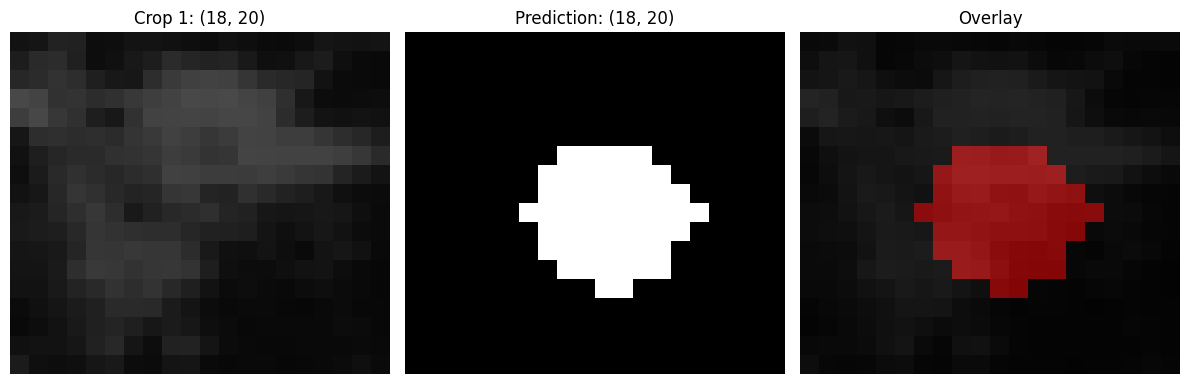

Box 1: Original crop size: (18, 20), Prediction size: (256, 256), Resized prediction: (18, 20)
Processing box 1: (110,176) to (130,194) - size: 20x18


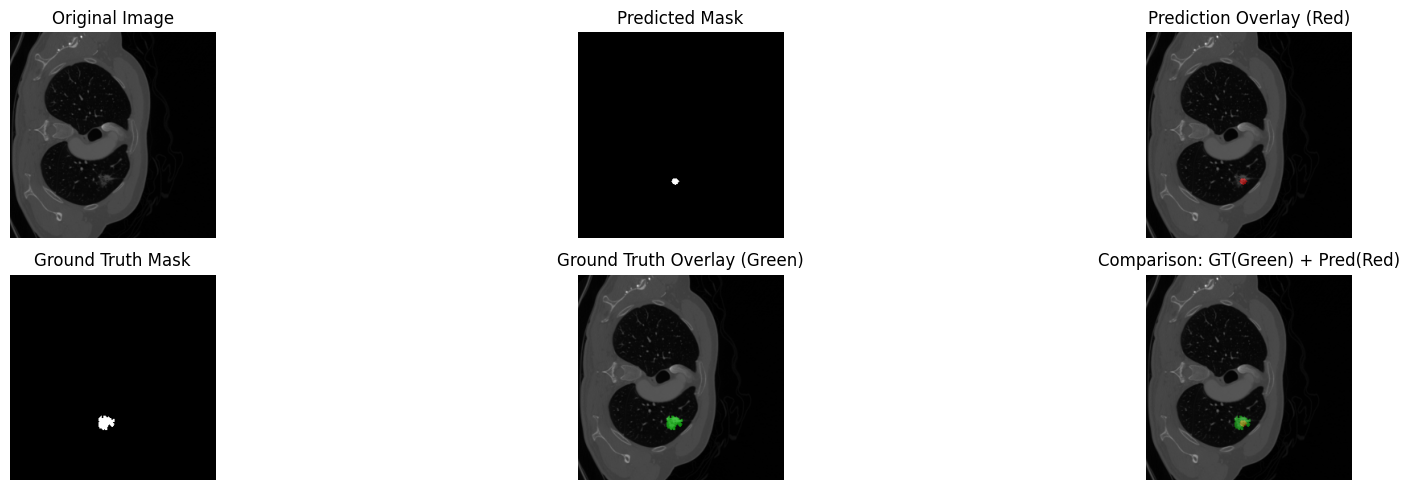

In [10]:
# First, debug individual crops to see if predictions look correct
test_img_path = "/kaggle/input/cv-data-set/val/images/Subject_58/280.png"
test_bbox_path = "/kaggle/input/cv-data-set/val/detections/Subject_58/280.txt"
test_mask_image = '/kaggle/input/cv-data-set/val/masks/Subject_58/280.png'
inference_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])
debug_segmentation_crops(
    model=model,
    image_path=test_img_path,
    bbox_path=test_bbox_path,
    device=device,
    transform=inference_transform
)

# Then run the full segmentation
results = segment_with_boxes(
    model=model,
    image_path=test_img_path,
    bbox_path=test_bbox_path,
    device=device,
    transform=inference_transform,
    gt_mask_path=test_mask_image
)

visualize_segmentation_results(results)

In [ ]:
torch.save({

            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),

        }, os.path.join('.', 'partila_seg_last_model.pth'))

In [11]:
def validate_model(loader, model, loss_fn, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.float().to(device).unsqueeze(1)


            logits = model(images)
            if isinstance(logits, dict):
                logits = logits['out']
            loss = loss_fn(logits, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).float()

            num_correct += (preds == masks).sum().item()
            num_pixels += torch.numel(preds)

            dice_score += (2 * (preds * masks).sum().item()) / (
                (preds + masks).sum().item() + 1e-8
            )

    avg_loss = total_loss / len(loader)
    avg_dice = dice_score / len(loader)
    acc = num_correct / num_pixels * 100

    print(f"[Validation] Acc: {acc:.2f}%, Dice: {avg_dice:.4f}, Loss: {avg_loss:.4f}")
    return avg_loss, avg_dice

In [12]:
class BCEDiceLoss(torch.nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        smooth = 1e-6
        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2 * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

loss_fn = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5).to(device)
validate_model(val_loader, model, loss_fn)

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same